## RQ1 Forest Definition Comparisons 

[Add description]

Steps
1. Analyse & Compare FNF maps for Natura 2000 areas 
    1. Generate zonal statistics
    2. Format into geodataframes
    3. Calculations
    4. ~~Visualisations~~
    5. Statistical Analysis
2. Create *Forest Presence/Absence Consensus Map* (Sexton et al 2016 approach)
3. Analyse Consensus Map for Natura 2000 areas
    1. Generate zonal statistics
    2. Format into geodataframe
    3. Calculations
    4. ~~Visualisations~~

4. Germany analysis?
**NOTE: for now I'm only doing statistics and comparisons for the Natura 2000 areas, but there is data for all of Germany - so I could do some similar calculations and comparisons for all of Germany. Rather than using zonal statistics, here I would just need to calculate the count and sum for each whole FNF raster. Alternatively, I could do zonal statistics using the CORINE footprint area.**


In [2]:
# SETUP

# Note: this .ipynb file depends on files & folder structures created in rq1_step1_data_prep.ipynb 
# and rq1_step2_fao_forest.ipynb

# Import packages
import os
import subprocess
import pickle
import pandas as pd
import glob
import matplotlib.pyplot as plt
import scipy

from rasterstats import zonal_stats
import geopandas as gpd
from shapely.geometry import shape

# Create required directories if they don't already exist
# Note: these directories are ignored in git
path_list = ["./outputs/figures"]

for path in path_list:
  if not os.path.exists(path):
    os.mkdir(path)
    print("Folder %s created!" % path)
  else:
    print("Folder %s already exists" % path)

# Store gdal.py paths
gdal_calc = "./thesis_env_conda/Lib/site-packages/GDAL-3.10.1-py3.12-win-amd64.egg-info/scripts/gdal_calc.py"

Folder ./outputs/figures already exists


### Step 1: Analyse & Compare FNF Maps for Natura 2000 areas

Generally, I will calculate the count (total pixels) and sum (total forest pixels) for the Natura 2000 areas for each FNF map. I will then perform additional calculations to generate results across all areas, and compare results across the different FNF maps.

#### Step 1.1: Generate zonal statistics

Zonal stats (sum and count) per geometry for each FNF map

Convert each to a feature collection

In [9]:
# 1.1: FNF NATURA ZONAL STATS 
# EACH OUTPUT TAKES ABUOT 30 MIN (3 HOURS TOTAL)

# Store paths to the FNF maps
esa_FNF = "./outputs/esa_lccs_class_3035_DE_5m_2018_FNF.tif"
jaxa_FNF = "./outputs/jaxa_FNF_3035_DE_5m_2018_FNF.tif"
corine_FNF = "./outputs/U2018_CLC2018_V2020_3035_DE_5m_2018_FNF.tif"
ger_lulc_FNF = "./outputs/clc5_class3xx_3035_DE_5m_2018_FNF.tif"
hansen_FNF = "./outputs/hansen_60cover_2018_3035_DE_5m_2018_FNF.tif"
fao_FNF = "./outputs/fao_approx_3035_DE_5m_2018_FNF.tif"

# Load the German Natura 2000 areas (w/o "RELEASE_DA" column as this causes problems later)
natura = gpd.read_file("./outputs/natura2000_3035_DE.shp", 
                       columns=["SITECODE", "SITENAME", "MS", "SITETYPE"])

# Calculate the sum & count for each Natura 2000 geometry, for each FNF map 
# Keep the geometeries by outputting in geojson format
esaFNF_natura_stats = zonal_stats(natura, esa_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

jaxaFNF_natura_stats = zonal_stats(natura, jaxa_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

corineFNF_natura_stats = zonal_stats(natura, corine_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)  

gerlulcFNF_natura_stats = zonal_stats(natura, ger_lulc_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

hansenFNF_natura_stats = zonal_stats(natura, hansen_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

faoFNF_natura_stats = zonal_stats(natura, fao_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

# Convert results to feature collections
esaFNF_natura_stats_fc = {"type": "FeatureCollection","features": esaFNF_natura_stats}
jaxaFNF_natura_stats_fc = {"type": "FeatureCollection","features": jaxaFNF_natura_stats}
corineFNF_natura_stats_fc = {"type": "FeatureCollection","features": corineFNF_natura_stats}
gerlulcFNF_natura_stats_fc = {"type": "FeatureCollection","features": gerlulcFNF_natura_stats}
hansenFNF_natura_stats_fc = {"type": "FeatureCollection","features": hansenFNF_natura_stats}
faoFNF_natura_stats_fc = {"type": "FeatureCollection","features": faoFNF_natura_stats}


#### Step 1.2: Format into geodataframes

Use some functions to extract the zonal statistics data (which is in geojson format) into lists and then convert these lists to geodataframes (geopandas).

At this point, I also save the outputs using pickle.dump() so that step 1.1 doesn't need to be run every time. 

In [10]:
# 1.2: EXTRACT INTO LISTS

# Extract features from the feature collections
esa_features = esaFNF_natura_stats_fc["features"]
jaxa_features = jaxaFNF_natura_stats_fc["features"]
corine_features = corineFNF_natura_stats_fc["features"]
gerlulc_features = gerlulcFNF_natura_stats_fc["features"]
hansen_features = hansenFNF_natura_stats_fc["features"]
fao_features = faoFNF_natura_stats_fc["features"]

# Create empty lists for the properties I'm interested in
esa_codes, esa_names, esa_types, esa_counts, esa_sums, esa_geoms = ([] for i in range(6))
jaxa_codes, jaxa_names, jaxa_types, jaxa_counts, jaxa_sums, jaxa_geoms = ([] for i in range(6))
cor_codes, cor_names, cor_types, cor_counts, cor_sums, cor_geoms = ([] for i in range(6))
ger_codes, ger_names, ger_types, ger_counts, ger_sums, ger_geoms = ([] for i in range(6))
hans_codes, hans_names, hans_types, hans_counts, hans_sums, hans_geoms = ([] for i in range(6))
fao_codes, fao_names, fao_types, fao_counts, fao_sums, fao_geoms = ([] for i in range(6))

# Create a function for filling lists (extracting according to json format)
def fill_lists(input_features, code_list, name_list, type_list, count_list, sum_list, geom_list):
    for row in input_features:
        code_list.append(row['properties']['SITECODE'])
        name_list.append(row['properties']['SITENAME'])
        type_list.append(row['properties']['SITETYPE'])
        count_list.append(row['properties']['count'])
        sum_list.append(row['properties']['sum'])
        geom_list.append(row['geometry'])

# Use the function to fill the lists
fill_lists(esa_features, esa_codes, esa_names, esa_types, esa_counts, esa_sums, esa_geoms)
fill_lists(jaxa_features, jaxa_codes, jaxa_names, jaxa_types, jaxa_counts, jaxa_sums, jaxa_geoms)
fill_lists(corine_features, cor_codes, cor_names, cor_types, cor_counts, cor_sums, cor_geoms)
fill_lists(gerlulc_features, ger_codes, ger_names, ger_types, ger_counts, ger_sums, ger_geoms)
fill_lists(hansen_features, hans_codes, hans_names, hans_types, hans_counts, hans_sums, hans_geoms)
fill_lists(fao_features, fao_codes, fao_names, fao_types, fao_counts, fao_sums, fao_geoms)


In [11]:
# 1.2: CREATE GDFS 

# Create a function for creating the geodataframes from the lists
def create_stats_gdf(code_list, name_list, type_list, count_list, sum_list, geom_list):
    gdf = gpd.GeoDataFrame({'site_code' : code_list,
                            'site_name' : name_list,
                            'site_type' : type_list,
                            'total_pixel_count' : count_list,
                            'forest_pixel_sum' : sum_list,
                            'geometry' : [shape(i) for i in geom_list] # Convert geometries to correct format
                            })
    return gdf

# Use the function to create the gdfs
esa_FNF_natura_stats_gdf = create_stats_gdf(esa_codes, esa_names, esa_types,  
                                            esa_counts, esa_sums, esa_geoms)
jaxa_FNF_natura_stats_gdf = create_stats_gdf(jaxa_codes, jaxa_names, jaxa_types,
                                             jaxa_counts, jaxa_sums, jaxa_geoms)
corine_FNF_natura_stats_gdf = create_stats_gdf(cor_codes, cor_names, cor_types,  
                                               cor_counts, cor_sums, cor_geoms)
gerlulc_FNF_natura_stats_gdf = create_stats_gdf(ger_codes, ger_names, ger_types,  
                                                ger_counts, ger_sums, ger_geoms)
hansen_FNF_natura_stats_gdf = create_stats_gdf(hans_codes, hans_names, hans_types, 
                                               hans_counts, hans_sums, hans_geoms)
fao_FNF_natura_stats_gdf = create_stats_gdf(fao_codes, fao_names, fao_types, 
                                            fao_counts, fao_sums, fao_geoms)



In [12]:
# 1.2: SAVE GDFS 

# Save the geodataframe (so preceeding steps only need to be run once)
pickle.dump(esa_FNF_natura_stats_gdf, open("./processing/esaFNF_natura_stats.p", "wb"))
pickle.dump(jaxa_FNF_natura_stats_gdf, open("./processing/jaxaFNF_natura_stats.p", "wb"))
pickle.dump(corine_FNF_natura_stats_gdf, open("./processing/corineFNF_natura_stats.p", "wb"))
pickle.dump(gerlulc_FNF_natura_stats_gdf, open("./processing/gerlulcFNF_natura_stats.p", "wb"))
pickle.dump(hansen_FNF_natura_stats_gdf, open("./processing/hansenFNF_natura_stats.p", "wb"))
pickle.dump(fao_FNF_natura_stats_gdf, open("./processing/faoFNF_natura_stats.p", "wb"))

In [3]:
# 1.2: LOAD GDFS 
# START FROM HERE WHEN RETURNING TO SCRIPT

# Load the zonal stats outputs 
esa_FNF_natura_stats_gdf = pickle.load(open("./processing/esaFNF_natura_stats.p", "rb"))
jaxa_FNF_natura_stats_gdf = pickle.load(open("./processing/jaxaFNF_natura_stats.p", "rb"))
corine_FNF_natura_stats_gdf = pickle.load(open("./processing/corineFNF_natura_stats.p", "rb"))
gerlulc_FNF_natura_stats_gdf = pickle.load(open("./processing/gerlulcFNF_natura_stats.p", "rb"))
hansen_FNF_natura_stats_gdf = pickle.load(open("./processing/hansenFNF_natura_stats.p", "rb"))
fao_FNF_natura_stats_gdf = pickle.load(open("./processing/faoFNF_natura_stats.p", "rb"))


#### Step 1.3: Calculations

**Per Geometry**
1. Convert count and sum to area values 
    - Each pixel is 5m x 5m = 25m2 or 0.0025 ha 
2. Use the total forest area (sum) and total area (count) values to calculate percentage forest for each geometry

**Per FNF map (for all Natura 2000 areas)**
3. Sum the per geometry sum and count area values to get the total forest and total area for all Natura 2000 areas, for each FNF map
4. Use the total forest and total area to get the percentage forest for each FNF map

**Comparisons**
5. Calculate the average forest area (all Natura 2000 areas) across all FNF maps (one result)
6. Calculate the difference from the average for each FNF map (step 3 total forest outputs minus step 5 output) 

In [14]:
# 1.3: PER GEOMETRY CALCULATIONS

# Create a list of all the gdfs with the Natura 2000 zonal stats results
gdf_list = [esa_FNF_natura_stats_gdf, jaxa_FNF_natura_stats_gdf, corine_FNF_natura_stats_gdf,
            gerlulc_FNF_natura_stats_gdf, hansen_FNF_natura_stats_gdf, fao_FNF_natura_stats_gdf]

# Create new columns for count and sum in area units (hectares)
for gdf in gdf_list:
    gdf["total_area_ha"] = gdf["total_pixel_count"] * 0.0025
    gdf["total_forest_ha"] = gdf["forest_pixel_sum"] * 0.0025

# Calculate the percentage of forest in each geometry
for gdf in gdf_list:
    gdf["percent_forest"] = (gdf["total_forest_ha"] / gdf["total_area_ha"]) * 100

# Check
jaxa_FNF_natura_stats_gdf[0:3]  

,site_code,site_name,site_type,total_pixel_count,forest_pixel_sum,geometry,total_area_ha,total_forest_ha,percent_forest
0,DE1522301,Kalkquellmoor bei Klein Rheide,B,7672,0.0,"POLYGON ((4286080.879 3484370.839, 4286192.964...",19.1800,0.000,0.000000
1,DE1631304,Seegalendorfer Gehölz,B,5089,4362.0,"POLYGON ((4383163.901 3467566.091, 4383189.582...",12.7225,10.905,85.714286
2,DE1728351,Kalkflachmoor bei Mucheln,B,4487,2726.0,"POLYGON ((4348889.555 3461513.635, 4348877.247...",11.2175,6.815,60.753287


In [15]:
# 1.3: PER FNF MAP CALCULATIONS

# Create list of names for FNF maps
fnf_map_names = ["ESA Land Cover", "JAXA Forest/Non-Forest", "CORINE Land Use",
                 "Germany Land Use", "Hansen Tree Cover", "FAO-Forest Approximation"]

# Create a new partially filled dataframe for storing the results
all_fnf_natura_stats = pd.DataFrame(fnf_map_names, columns = ["FNF Map"])

# Create empty lists for total forest values & total area values
forest_per_FNF = []
area_per_FNF = []

# Calculate the total forest in Natura 2000 areas for each FNF map & append to list
for gdf in gdf_list:
    total_forest = gdf["total_forest_ha"].sum()
    forest_per_FNF.append(total_forest)

    total_area = gdf["total_area_ha"].sum()
    area_per_FNF.append(total_area)    # These should all be the same results for each FNF map

# Add the total forest values and total area values to the df
all_fnf_natura_stats["Total Forest (ha)"] = forest_per_FNF
#all_fnf_natura_stats["Total Area (ha)"] = area_per_FNF

# Extract just the corine area (see notes below for why this is used for the % calc)
corine_area = area_per_FNF[2]

# Calculate the percentage of forest cover for each FNF map
all_fnf_natura_stats["Percent Forest (%)"] = (all_fnf_natura_stats["Total Forest (ha)"] / 
                                              corine_area) * 100

all_fnf_natura_stats



,FNF Map,Total Forest (ha),Percent Forest (%)
0,ESA Land Cover,3.870882e+06,53.407329
1,JAXA Forest/Non-Forest,3.858510e+06,53.236626
2,CORINE Land Use,4.114077e+06,56.762742
3,Germany Land Use,4.142021e+06,57.148291
4,Hansen Tree Cover,3.527466e+06,48.669147
5,FAO-Forest Approximation,4.185290e+06,57.745275


**NOTE** 
In the code above I calculte the total area of the Natura geometries using the pixel count generated from the zonal statistics of the layer. I noted in the code that these results should be the same across all FNF results. If you uncomment the line which adds the area calculations to the dataframe, you can see that the area results are slightly different for the GER LULC map and the FAO-Forest Approximation map. 

After exploring the results in QGIS, I noticed this is because the GER LULC map has a very slightly different footprint to other rasters, with a small portion on the eastern edge missing from the GER LULC map (making the total count area slightly less). The 2 Natura areas affected have sitecodes 'DE4454302' and 'DE4454451' This has a knock-on effect to the FAO map as it is created from the GER LULC map.

Unfortunately, I think this is a limitation of the original GER LULC data itself. However, when looking at the CORINE data (which the GER LULC data is very similar to), there is no forest in this area that is missing from the GER LULC map. I therefore think that this has very little effect on the final maps. 

**OUTCOMES/DECSIONS**
I assume that there is no forest in the missing area in the GER LULC map. To calculate the percentage of forest cover in a standardised way, I use the total CORINE area for all maps.

For the FAO-Approximation map, the missing area in the GER LULC map means that any JAXA forest in this area is not considered. There is a very small area of forest in the JAXA map which has been missed. Using the measuring tools in QGIS, I estimated the area of forest  in the JAXA map within a Natura geometry (that is therefore missing from the FAO map) is only about 2050m2 or 0.205 ha. As the total forest in the 2 areas affected is about 731 ha and 800 ha (the 2 areas mainly overlap with each other with only slightly different boundaries), this corresponds to only 0.028% or 0.026% (and an even tinier number when considering the results across all Natura areas). In this case, I think it is okay to just leave things as they are and describe this small error in the thesis. 


In [16]:
# 1.3: COMPARISON CALCULATIONS

# Calculate the average forest area across maps
avg_forest_area = all_fnf_natura_stats["Total Forest (ha)"].mean()

# Calculate the difference of each map to the average
avg_diff = all_fnf_natura_stats["Total Forest (ha)"] - avg_forest_area

# Add the difference results to the df
all_fnf_natura_stats["Difference from Mean (ha)"] = avg_diff

# Calculate the sum of each map with the average (for next step)
avg_sum = all_fnf_natura_stats["Total Forest (ha)"] + avg_forest_area

# Calculate the percent difference results to the df
percent_diff = (abs(avg_diff) / (avg_sum / 2)) * 100

# Add the percent difference results to the df
all_fnf_natura_stats["Difference from Mean (%)"] = percent_diff

all_fnf_natura_stats


,FNF Map,Total Forest (ha),Percent Forest (%),Difference from Mean (ha),Difference from Mean (%)
0,ESA Land Cover,3.870882e+06,53.407329,-78825.60875,2.015848
1,JAXA Forest/Non-Forest,3.858510e+06,53.236626,-91197.90625,2.335947
2,CORINE Land Use,4.114077e+06,56.762742,164369.59625,4.076736
3,Germany Land Use,4.142021e+06,57.148291,192313.60875,4.753338
4,Hansen Tree Cover,3.527466e+06,48.669147,-422241.80875,11.294156
5,FAO-Forest Approximation,4.185290e+06,57.745275,235582.11875,5.791818


#### Step 1.4: Visualisations

- Make a prettier table output out of the df (FNF Map, Total Forest, Percent Forest & Difference)
- Create a bar chart of total forest per FNF map with dashed line for mean

- ~~Show all FNF maps?~~ (decided against - not needed with the consensus map)
- ~~Create a map series of total forest (both absolute and relative for now) per geometry, per FNF map~~ (decided against - I would need to separate out for sitetype as well because of the overlaps which would then result in 3 * 2 * 6 maps = 36 maps, which is not very practical to show)

** In the end I decided to do the visualisations outside of Python, so for this step I will actually just export the data to work with in R and QGIS.


In [17]:
# 1.4: EXPORT PER GEOM RESULTS

# Set the projection information for the gdfs
esa_FNF_natura_stats_gdf.set_crs("EPSG:3035")
jaxa_FNF_natura_stats_gdf.set_crs("EPSG:3035")
corine_FNF_natura_stats_gdf.set_crs("EPSG:3035")
gerlulc_FNF_natura_stats_gdf.set_crs("EPSG:3035")
hansen_FNF_natura_stats_gdf.set_crs("EPSG:3035")
fao_FNF_natura_stats_gdf.set_crs("EPSG:3035")

# Save the per geometry results for each FNF map as shapefiles
esa_FNF_natura_stats_gdf.to_file("./outputs/esa_FNF_natura_stats_per_geom.shp")
jaxa_FNF_natura_stats_gdf.to_file("./outputs/jaxa_FNF_natura_stats_per_geom.shp")
corine_FNF_natura_stats_gdf.to_file("./outputs/corine_FNF_natura_stats_per_geom.shp")
gerlulc_FNF_natura_stats_gdf.to_file("./outputs/gerlulc_FNF_natura_stats_per_geom.shp")
hansen_FNF_natura_stats_gdf.to_file("./outputs/hansen_FNF_natura_stats_per_geom.shp")
fao_FNF_natura_stats_gdf.to_file("./outputs/fao_FNF_natura_stats_per_geom.shp")


C:\Users\ninam\AppData\Local\Temp\ipykernel_6120\2112436837.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  esa_FNF_natura_stats_gdf.to_file("./outputs/esa_FNF_natura_stats_per_geom.shp")
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_forest_thesis\thesis_env_conda\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_forest_thesis\thesis_env_conda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_pixel_count' to 'total_pixe'
  ogr_write(
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_forest_thesis\thesis_env_conda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'forest_pixel_sum' to 'forest_pix'
  ogr_write(
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_fore

In [9]:
# 1.4: EXPORT SUMMARY FNF RESULTS

# Export the df as a csv
all_fnf_natura_stats.to_csv("./outputs/all_fnf_natura_stats.csv")

#### Step 1.5: Statistical Analysis

In this section I take a look at the forest cover per Natura area and run a pair-wise (paired) t-test to check if there are significant differences between FNF maps (definitions/operationalisations).

First I prepare the data by merging all results into one dataframe. 


In [3]:
# 1.5: PREP DATA FOR ANALYSIS

# Create loading function with desired columns
def ttest_gdf_loader(input_path):
    file = gpd.read_file(input_path, columns=["site_code", "total_fore", "percent_fo"])
    return file

# Load the data from the saved shps (doing this way so this code chunk can stand on its own) 
esa_ttest_gdf = ttest_gdf_loader("./outputs/esa_FNF_natura_stats_per_geom.shp")
jaxa_ttest_gdf = ttest_gdf_loader("./outputs/jaxa_FNF_natura_stats_per_geom.shp")
corine_ttest_gdf = ttest_gdf_loader("./outputs/corine_FNF_natura_stats_per_geom.shp")
gerlulc_ttest_gdf = ttest_gdf_loader("./outputs/gerlulc_FNF_natura_stats_per_geom.shp")
hansen_ttest_gdf = ttest_gdf_loader("./outputs/hansen_FNF_natura_stats_per_geom.shp")
fao_FNF_ttest_gdf = ttest_gdf_loader("./outputs/fao_FNF_natura_stats_per_geom.shp")

# Renaming function 
# adds prefix so forest results can be distinguished from eachother when joined
def ttest_col_rename(gdf, prefix):
    gdf.columns=(prefix + "_forest_per", "site_code", prefix + "_forest_ha", "geometry")
    
# Rename columns
ttest_col_rename(esa_ttest_gdf, "esa")
ttest_col_rename(jaxa_ttest_gdf, "jaxa")
ttest_col_rename(corine_ttest_gdf, "corine")
ttest_col_rename(gerlulc_ttest_gdf, "gerlulc")
ttest_col_rename(hansen_ttest_gdf, "hansen")
ttest_col_rename(fao_FNF_ttest_gdf, "fao")

# Drop geometry columns and convert to regular dataframe
esa_ttest_df = pd.DataFrame(esa_ttest_gdf.drop(columns='geometry'))
jaxa_ttest_df = pd.DataFrame(jaxa_ttest_gdf.drop(columns='geometry'))
corine_ttest_df = pd.DataFrame(corine_ttest_gdf.drop(columns='geometry'))
gerlulc_ttest_df = pd.DataFrame(gerlulc_ttest_gdf.drop(columns='geometry'))
hansen_ttest_df = pd.DataFrame(hansen_ttest_gdf.drop(columns='geometry'))
fao_FNF_ttest_df = pd.DataFrame(fao_FNF_ttest_gdf.drop(columns='geometry'))

# Join gdfs together (non-spatial merge on site_code)
all_ttest_data = esa_ttest_df.merge(jaxa_ttest_df, on="site_code")
all_ttest_data = all_ttest_data.merge(corine_ttest_df, on = "site_code")
all_ttest_data = all_ttest_data.merge(gerlulc_ttest_df, on = "site_code")
all_ttest_data = all_ttest_data.merge(hansen_ttest_df, on = "site_code")
all_ttest_data = all_ttest_data.merge(fao_FNF_ttest_df, on = "site_code")

# Drop null rows - these are 27 rows where the Natura area is outside of the FNF rasters 
# They are the same geometries across all FNF maps so its safe to just drop the rows entirely
all_ttest_data = all_ttest_data.dropna(how='any',axis=0)

# Check results
all_ttest_data

,esa_forest_per,site_code,esa_forest_ha,jaxa_forest_per,jaxa_forest_ha,corine_forest_per,corine_forest_ha,gerlulc_forest_per,gerlulc_forest_ha,hansen_forest_per,hansen_forest_ha,fao_forest_per,fao_forest_ha
0,0.000000,DE1522301,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000
1,0.000000,DE1631304,0.0000,85.714286,10.9050,95.676950,12.1725,94.910591,12.0750,87.109452,11.0825,94.910591,12.0750
2,0.000000,DE1728351,0.0000,60.753287,6.8150,0.000000,0.0000,49.253399,5.5250,49.387118,5.5400,49.253399,5.5250
3,35.770636,DE2142301,251.3075,49.464275,347.5125,43.218122,303.6300,47.796784,335.7975,41.449571,291.2050,48.108504,337.9875
4,0.000000,DE2314431,0.0000,63.154676,162.6675,24.840820,63.9825,29.495865,75.9725,5.776100,14.8775,68.757037,177.0975
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,77.495013,DE2527421,116.5525,78.301197,117.7650,84.707447,127.4000,84.883644,127.6650,72.327128,108.7800,84.883644,127.6650
5196,87.697515,DE2548301,296.6500,97.227765,328.8875,98.758370,334.0650,99.105731,335.2400,96.401490,326.0925,99.105731,335.2400
5197,0.000000,DE2549303,0.0000,7.019608,0.8950,0.000000,0.0000,0.137255,0.0175,9.392157,1.1975,0.137255,0.0175
5198,0.000000,DE2549304,0.0000,43.804687,77.8475,31.999268,56.8675,36.014124,64.0025,36.747039,65.3050,41.081226,73.0075


**Paired T-Tests**

Steps
1. Check that the differences between each compared map follows a normal distribution
    - Calculate and test the differences for normality with the Shapiro test. CORRECTION: the Shapiro test is not guaranteed to produce an accurate p-value for n > 5000 (mine is 5173), so instead I plot all difference distributions to visually check for normality.
2. If the distribution is normal, use scipy.stats.ttest_rel on each pair of FNF maps with the alpha value as described above. If the distribution is not normal then the scipy.stats.wilcoxon can be used.
3. To understand the statstical results, create box plots.

**IMPORTANT:** Because I'm running multiple paired t-tests, this results in the "multiple comparisons problem" where the chance of a Type I Error (rejecting null hypothesis when it should not have been) becomes higher. To account for this problem, one can set a stricter significance threshold, and the Bonferroni correction is a common method where you adjust the desired alpha value by dividing my the number of tests being run. 

In my case, this means that a= 0.05 / 15 (there are 15 tests being run for each different map pair), so **a = 0.0033**



In [4]:
# 1.5: CALCULATE DIFFERENCES FOR ANALYSIS (ABOSLUTE)

# Create an empty dataframe for storing only the differences
all_ttest_data_diffs = pd.DataFrame()

# Calculate the ABSOLUTE differences between all possible FNF map pairs (15)
all_ttest_data_diffs["diff_esa_jaxa"] = all_ttest_data["esa_forest_ha"] - all_ttest_data["jaxa_forest_ha"]
all_ttest_data_diffs["diff_esa_corine"] = all_ttest_data["esa_forest_ha"] - all_ttest_data["corine_forest_ha"]
all_ttest_data_diffs["diff_esa_gerlulc"] = all_ttest_data["esa_forest_ha"] - all_ttest_data["gerlulc_forest_ha"]
all_ttest_data_diffs["diff_esa_hansen"] = all_ttest_data["esa_forest_ha"] - all_ttest_data["hansen_forest_ha"]
all_ttest_data_diffs["diff_esa_fao"] = all_ttest_data["esa_forest_ha"] - all_ttest_data["fao_forest_ha"]

all_ttest_data_diffs["diff_jaxa_corine"] = all_ttest_data["jaxa_forest_ha"] - all_ttest_data["corine_forest_ha"]
all_ttest_data_diffs["diff_jaxa_gerlulc"] = all_ttest_data["jaxa_forest_ha"] - all_ttest_data["gerlulc_forest_ha"]
all_ttest_data_diffs["diff_jaxa_hansen"] = all_ttest_data["jaxa_forest_ha"] - all_ttest_data["hansen_forest_ha"]
all_ttest_data_diffs["diff_jaxa_fao"] = all_ttest_data["jaxa_forest_ha"] - all_ttest_data["fao_forest_ha"]

all_ttest_data_diffs["diff_corine_gerlulc"] = all_ttest_data["corine_forest_ha"] - all_ttest_data["gerlulc_forest_ha"]
all_ttest_data_diffs["diff_corine_hansen"] = all_ttest_data["corine_forest_ha"] - all_ttest_data["hansen_forest_ha"]
all_ttest_data_diffs["diff_corine_fao"] = all_ttest_data["corine_forest_ha"] - all_ttest_data["fao_forest_ha"]

all_ttest_data_diffs["diff_gerlulc_hansen"] = all_ttest_data["gerlulc_forest_ha"] - all_ttest_data["hansen_forest_ha"]
all_ttest_data_diffs["diff_gerlulc_fao"] = all_ttest_data["gerlulc_forest_ha"] - all_ttest_data["fao_forest_ha"]

all_ttest_data_diffs["diff_hansen_fao"] = all_ttest_data["hansen_forest_ha"] - all_ttest_data["fao_forest_ha"]

# Check results
all_ttest_data_diffs

,diff_esa_jaxa,diff_esa_corine,diff_esa_gerlulc,diff_esa_hansen,diff_esa_fao,diff_jaxa_corine,diff_jaxa_gerlulc,diff_jaxa_hansen,diff_jaxa_fao,diff_corine_gerlulc,diff_corine_hansen,diff_corine_fao,diff_gerlulc_hansen,diff_gerlulc_fao,diff_hansen_fao
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-10.9050,-12.1725,-12.0750,-11.0825,-12.0750,-1.2675,-1.1700,-0.1775,-1.1700,0.0975,1.0900,0.0975,0.9925,0.0000,-0.9925
2,-6.8150,0.0000,-5.5250,-5.5400,-5.5250,6.8150,1.2900,1.2750,1.2900,-5.5250,-5.5400,-5.5250,-0.0150,0.0000,0.0150
3,-96.2050,-52.3225,-84.4900,-39.8975,-86.6800,43.8825,11.7150,56.3075,9.5250,-32.1675,12.4250,-34.3575,44.5925,-2.1900,-46.7825
4,-162.6675,-63.9825,-75.9725,-14.8775,-177.0975,98.6850,86.6950,147.7900,-14.4300,-11.9900,49.1050,-113.1150,61.0950,-101.1250,-162.2200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,-1.2125,-10.8475,-11.1125,7.7725,-11.1125,-9.6350,-9.9000,8.9850,-9.9000,-0.2650,18.6200,-0.2650,18.8850,0.0000,-18.8850
5196,-32.2375,-37.4150,-38.5900,-29.4425,-38.5900,-5.1775,-6.3525,2.7950,-6.3525,-1.1750,7.9725,-1.1750,9.1475,0.0000,-9.1475
5197,-0.8950,0.0000,-0.0175,-1.1975,-0.0175,0.8950,0.8775,-0.3025,0.8775,-0.0175,-1.1975,-0.0175,-1.1800,0.0000,1.1800
5198,-77.8475,-56.8675,-64.0025,-65.3050,-73.0075,20.9800,13.8450,12.5425,4.8400,-7.1350,-8.4375,-16.1400,-1.3025,-9.0050,-7.7025


In [5]:
# 1.5: CALCULATE DIFFERENCES FOR ANALYSIS (RELATIVE)

# Create an empty dataframe for storing only the differences 
all_ttest_data_diffs_rel = pd.DataFrame()

# Calculate the RELATIVE/PERCENT differences between all possible FNF map pairs (15)
all_ttest_data_diffs_rel["diff_esa_jaxa"] = all_ttest_data["esa_forest_per"] - all_ttest_data["jaxa_forest_per"]
all_ttest_data_diffs_rel["diff_esa_corine"] = all_ttest_data["esa_forest_per"] - all_ttest_data["corine_forest_per"]
all_ttest_data_diffs_rel["diff_esa_gerlulc"] = all_ttest_data["esa_forest_per"] - all_ttest_data["gerlulc_forest_per"]
all_ttest_data_diffs_rel["diff_esa_hansen"] = all_ttest_data["esa_forest_per"] - all_ttest_data["hansen_forest_per"]
all_ttest_data_diffs_rel["diff_esa_fao"] = all_ttest_data["esa_forest_per"] - all_ttest_data["fao_forest_per"]

all_ttest_data_diffs_rel["diff_jaxa_corine"] = all_ttest_data["jaxa_forest_per"] - all_ttest_data["corine_forest_per"]
all_ttest_data_diffs_rel["diff_jaxa_gerlulc"] = all_ttest_data["jaxa_forest_per"] - all_ttest_data["gerlulc_forest_per"]
all_ttest_data_diffs_rel["diff_jaxa_hansen"] = all_ttest_data["jaxa_forest_per"] - all_ttest_data["hansen_forest_per"]
all_ttest_data_diffs_rel["diff_jaxa_fao"] = all_ttest_data["jaxa_forest_per"] - all_ttest_data["fao_forest_per"]

all_ttest_data_diffs_rel["diff_corine_gerlulc"] = all_ttest_data["corine_forest_per"] - all_ttest_data["gerlulc_forest_per"]
all_ttest_data_diffs_rel["diff_corine_hansen"] = all_ttest_data["corine_forest_per"] - all_ttest_data["hansen_forest_per"]
all_ttest_data_diffs_rel["diff_corine_fao"] = all_ttest_data["corine_forest_per"] - all_ttest_data["fao_forest_per"]

all_ttest_data_diffs_rel["diff_gerlulc_hansen"] = all_ttest_data["gerlulc_forest_per"] - all_ttest_data["hansen_forest_per"]
all_ttest_data_diffs_rel["diff_gerlulc_fao"] = all_ttest_data["gerlulc_forest_per"] - all_ttest_data["fao_forest_per"]

all_ttest_data_diffs_rel["diff_hansen_fao"] = all_ttest_data["hansen_forest_per"] - all_ttest_data["fao_forest_per"]

# Check results
all_ttest_data_diffs_rel

,diff_esa_jaxa,diff_esa_corine,diff_esa_gerlulc,diff_esa_hansen,diff_esa_fao,diff_jaxa_corine,diff_jaxa_gerlulc,diff_jaxa_hansen,diff_jaxa_fao,diff_corine_gerlulc,diff_corine_hansen,diff_corine_fao,diff_gerlulc_hansen,diff_gerlulc_fao,diff_hansen_fao
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-85.714286,-95.676950,-94.910591,-87.109452,-94.910591,-9.962665,-9.196306,-1.395166,-9.196306,0.766359,8.567499,0.766359,7.801140,0.000000,-7.801140
2,-60.753287,0.000000,-49.253399,-49.387118,-49.253399,60.753287,11.499889,11.366169,11.499889,-49.253399,-49.387118,-49.253399,-0.133720,0.000000,0.133720
3,-13.693639,-7.447486,-12.026148,-5.678935,-12.337868,6.246152,1.667491,8.014704,1.355771,-4.578661,1.768551,-4.890382,6.347212,-0.311720,-6.658933
4,-63.154676,-24.840820,-29.495865,-5.776100,-68.757037,38.313856,33.658811,57.378577,-5.602361,-4.655045,19.064720,-43.916217,23.719766,-39.261172,-62.980937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,-0.806184,-7.212434,-7.388630,5.167886,-7.388630,-6.406250,-6.582447,5.974069,-6.582447,-0.176197,12.380319,-0.176197,12.556516,0.000000,-12.556516
5196,-9.530250,-11.060855,-11.408215,-8.703975,-11.408215,-1.530605,-1.877966,0.826275,-1.877966,-0.347361,2.356880,-0.347361,2.704241,0.000000,-2.704241
5197,-7.019608,0.000000,-0.137255,-9.392157,-0.137255,7.019608,6.882353,-2.372549,6.882353,-0.137255,-9.392157,-0.137255,-9.254902,0.000000,9.254902
5198,-43.804687,-31.999268,-36.014124,-36.747039,-41.081226,11.805419,7.790564,7.057648,2.723462,-4.014855,-4.747770,-9.081957,-0.732915,-5.067102,-4.334187


In [ ]:
# 1.5: CHECK DIFFERENCES FOR NORMALITY (ABSOLUTE)

# For each column in the difference dataframe, generate a probplot
# If the values follow the diagonal line, they are normally distributed 
for column in all_ttest_data_diffs.columns:
    plt.rcParams["figure.figsize"] = (5,3)
    plt.figure()  # Create a new figure for each iteration
    scipy.stats.probplot(all_ttest_data_diffs[column], 
                         dist="norm", 
                         plot=plt)
    plt.title(column)
    plt.show()


In [ ]:
# 1.5: CHECK DIFFERENCES FOR NORMALITY (RELATIVE)

# For each column in the difference dataframe, generate a probplot
# If the values follow the diagonal line, they are normally distributed 
for column in all_ttest_data_diffs_rel.columns:
    plt.rcParams["figure.figsize"] = (5,3)
    plt.figure()  # Create a new figure for each iteration
    scipy.stats.probplot(all_ttest_data_diffs_rel[column], 
                         dist="norm", 
                         plot=plt)
    plt.title(column)
    plt.show()

The plots above show that the differences are **not** normally distributed (they do not follow the diagonal line indicating normal distribution).

I should therefore use a non-parametric paired t-test (i.e. wilcoxon).

In [ ]:
# 1.5: RUN WILCOXON TEST ON DIFFERENCES (ABSOLUTE)

# Create empty lists for storing information
test_names = []
test_statistics = []
test_pvalues = []

# Run the wilcoxon test on all the differences
# If only one data array is provided, it is assumed this array is the difference between two arrays
for column in all_ttest_data_diffs.columns:
    test_names.append(column)
    test = scipy.stats.wilcoxon(all_ttest_data_diffs[column])
    test_statistics.append(test.statistic)
    test_pvalues.append(test.pvalue)

# Create an empty df for storing all the results
all_ttest_results = pd.DataFrame()

# Fill in the df with the test results
all_ttest_results["comparison"] = test_names
all_ttest_results["statistic"] = test_statistics
all_ttest_results["pvalue"] = test_pvalues

# Show all the results
all_ttest_results

,comparison,statistic,pvalue
0,diff_esa_jaxa,5584135.5,7.697842e-10
1,diff_esa_corine,3904053.5,4.362460e-33
2,diff_esa_gerlulc,4023883.0,2.484142e-62
3,diff_esa_hansen,5567080.5,3.245677e-11
4,diff_esa_fao,3802973.0,5.106327e-83
5,diff_jaxa_corine,5798640.0,2.259841e-04
6,diff_jaxa_gerlulc,4818554.0,3.602387e-42
7,diff_jaxa_hansen,3831667.5,4.545881e-129
8,diff_jaxa_fao,4193399.0,1.601831e-86
9,diff_corine_gerlulc,4201841.5,7.785010e-39


The reuslts above show that **all differences are significant for a = 0.0033**! This was a bit unexpected so I generate some box plots and also explore the relative differences to look at the data further and see if this makes sense. **PLEASE SEE NOTES BELOW FOR THE RELATIVE DIFFERENCE STATISTICAL TEST RESULTS**

There is also a strange result for diff_gerlulc_fao where the test statistic = 0. The reason the test statistic is 0 is because of several factors:
- The test statistic corresponds to "the sum of the ranks of the differences above or below zero, whichever is smaller" (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)
- The fao forest is essentially the gerlulc forest PLUS some areas of jaxa forest. This means that the difference (ger minus fao) is ALWAYS negative (there are NO positive differences).
- This means that, in this case, the sum of the positive ranks is always 0 (there are no positive ranks), and the sum of the negative ranks is always greater than 0 (I think here the absolute of the negative rank sum is taken). This is also summarised in the answer to a question on Stackexchange: "It is very natural to get a value of W = 0, especially in Wilcoxon matched pair test. This happens when the values of all the observations in the "after" category are bigger / larger / higher than that in the "before" category. This generates all negative differences, and while these would still be ranked, all the ranks will be negative. Since there won't be any positive ranks, W would evaluate to 0." (https://stats.stackexchange.com/questions/401064/wilcoxon-test-gives-w-0)

I think that this means that the Wilcoxon test here is not super meaningful / not the most appropriate. Because all differences are below 0 the result is significant, even though the difference from 0 might not necessarily be large. 

Side note: For ranking, all differences are assigned a rank based on their absolute value (so negative signs are ignored). Once the ranks are assigned, the ranks which correspond to a negative difference are given a negative sign. (https://www.jstor.org/stable/3001968?origin=crossref&seq=3). For example, the differences 41,-48,51,-99 are first given ranks 1,2,3,4 and then this is converted to 1,-2,3,-4

In [31]:
# 1.5: RUN WILCOXON TEST ON DIFFERENCES (RELATIVE)

# Create empty lists for storing information
test_names_rel = []
test_statistics_rel = []
test_pvalues_rel = []

# Run the wilcoxon test on all the differences
# If only one data array is provided, it is assumed this array is the difference between two arrays
for column in all_ttest_data_diffs_rel.columns:
    test_names_rel.append(column)
    test = scipy.stats.wilcoxon(all_ttest_data_diffs_rel[column])
    test_statistics_rel.append(test.statistic)
    test_pvalues_rel.append(test.pvalue)

# Create an empty df for storing all the results
all_ttest_results_rel = pd.DataFrame()

# Fill in the df with the test results
all_ttest_results_rel["comparison"] = test_names_rel
all_ttest_results_rel["statistic"] = test_statistics_rel
all_ttest_results_rel["pvalue"] = test_pvalues_rel

# Show all the results
all_ttest_results_rel

,comparison,statistic,pvalue
0,diff_esa_jaxa,5126382.0,1.593503e-26
1,diff_esa_corine,3979214.0,1.215683e-28
2,diff_esa_gerlulc,3972516.0,2.264084e-66
3,diff_esa_hansen,5948866.5,3.834814e-03
4,diff_esa_fao,3758881.0,5.367662e-87
5,diff_jaxa_corine,6109275.0,5.382474e-01
6,diff_jaxa_gerlulc,5111640.5,8.349431e-27
7,diff_jaxa_hansen,3766722.0,8.610620e-136
8,diff_jaxa_fao,4569934.5,1.285996e-57
9,diff_corine_gerlulc,3903206.5,9.422267e-60


**Why do the relative differences yield different results?** 
Here everything is significant EXCEPT the jaxa_corine combination and the esa_hansen combination. I was originally not expecting therse results to be different from the absolute results; since we are comparing pairs of geometries which have the same total area, I thought it would not matter whether absolute or relative differences are used. However, **because the statistical test uses a ranking system, using the absolute or relative values does make a difference!** To explore this I looked at a subset of results from the jaxa_corine combination:

| Difference - Absolute | Rank - Absolute | Difference - Relative | Rank - Relative  |
| --------------------- | --------------- | --------------------- | ---------------- |
| 0                     | --              | 0                     | --               |
| -1.3                  | -2              | -10                   | -6               |
| 6.8                   | 4               | 60.8                  | 9                |
| 43.9                  | 8               | 6.2                   | 3                |
| 98.7                  | 9               | 38.3                  | 8                |
| -9.6                  | -5              | -6.4                  | -4               |
| -5.2                  | -3              | -1.5                  | -2               |
| 0.9                   | 1               | 7.0                   | 5                |
| 21.0                  | 7               | 11.8                  | 7                |
| -10.4                 | -6              | -1.3                  | -1               |

*See explantion in text chunk above for how the ranking works (particularly for negative values)

For the **absolute difference ranks**, the sum of the positive ranks is 29, and the sum of the negative ranks is -16 (abs =16). The test statistic (the lowest of the two) is therefore **16**. 

For the **relative difference ranks**, the sum of the positive ranks is 77, and the sum of the negative ranks is -13 (abs = 13). The test statistic (the lowest of the two) is therefore **13**. 

This shows that the test statistic (which has a knock-on effect to the pvalue) is different depending on whether the absolute or relative differences are used.

I think both are valid, it depends which perspective I want to look at the data from: the absolute forest difference provides the perspective of looking at the forests in the Natura 2000 areas as whole, whereas the relative difference gives equal prominence to all Natura 2000 sites and the forest within them, no matter their size.

**Box plots**

Create 2 box plots: 
1. Create one of the forest areas for each Natura area for each FNF map to see how the distributions are different (using **all_ttest_data** df)
2. Create one of the differences between combinations and instead of visually comparing boxes with each other, compare how the boxes are different from zero (using **all_ttest_data_diffs** df) 

For boxplots:
- Whiskers= minimum & maximum
- Box Boundaries = 1st quartile & 3rd quartile
- Orange line (middle of box) = Median

Help with box plots = https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/ 

**NOTE**: I originally created the absolute plots and then added the relative plots as well because the originals were very difficult to read with the large data range (I figured plotting the percentage of forest cover and relative differences would help to make things clearer as the data range would be much smaller). Since they were not helpful for visualising the data, I have removed the absolute plots from the code.


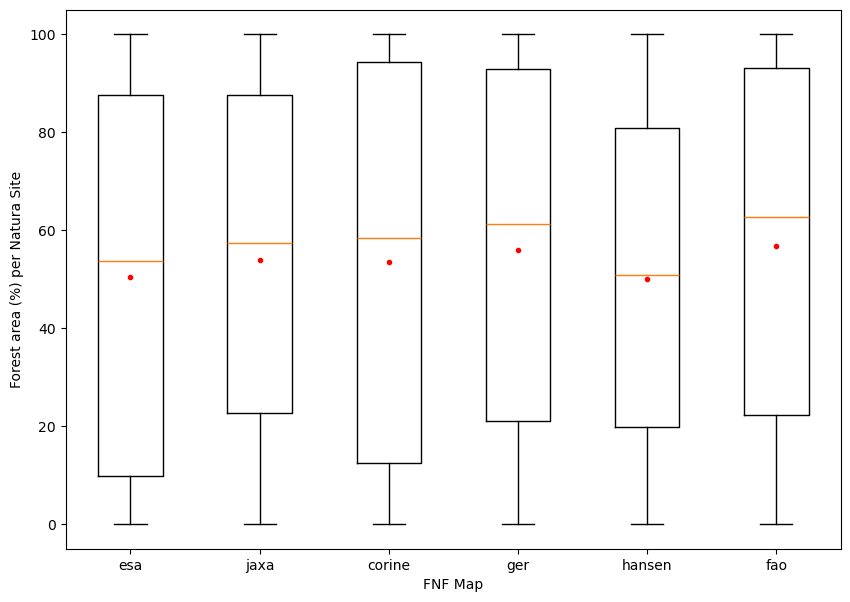

In [ ]:
# 1.5: BOX PLOT FOR FOREST PER MAP (PERCENT COVER / RELATIVE)

# Preparing figure
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating axes instance (data trimmed to remove site_code column, mean shown)
bp_per_map = ax.boxplot(all_ttest_data.iloc[:, [0,3,5,7,9,11]],
                        showmeans=True,
                        meanprops=dict(marker='.', markeredgecolor='red',
                                        markerfacecolor='red'))

# Change the style of the outliers ("fliers")
for flier in bp_per_map['fliers']:
    flier.set(marker ='.',
              color ='#e7298a',
              alpha = 0.5)

# Change the x-axis tick labels
plt.xticks([1,2,3,4,5,6], ["esa", "jaxa", "corine", "ger", "hansen", "fao"])


# Set the axis labels
ax.set_xlabel('FNF Map', fontsize = 10)
ax.set_ylabel('Forest area (%) per Natura Site', fontsize = 10)

# Show the plot
plt.show()


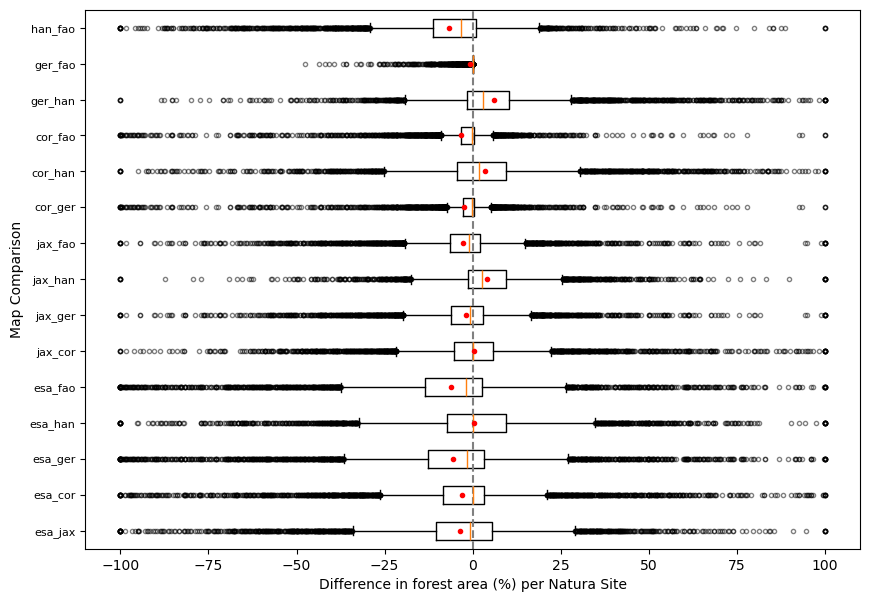

In [69]:
# 1.5: BOX PLOT FOR FOREST DIFFERENCES (RELATIVE)

# Preparing figure
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating plot (make a horizontal version and show the mean)
bp_per_diff_rel = ax.boxplot(all_ttest_data_diffs_rel,
                         vert = False,
                         showmeans=True,
                         meanprops=dict(marker='.', markeredgecolor='red',
                                        markerfacecolor='red'))

# Change the style of the outliers ("fliers")
for flier in bp_per_diff_rel['fliers']:
    flier.set(marker = '.',
              color ='#e7298a',
              alpha = 0.5)

# Change the y-axis tick labels & adjust size
plt.yticks(range(1, 16), ["esa_jax", "esa_cor", "esa_ger", "esa_han", "esa_fao", "jax_cor", 
                          "jax_ger", "jax_han", "jax_fao", "cor_ger", "cor_han", "cor_fao", 
                          "ger_han", "ger_fao", "han_fao"
                          ])
plt.yticks(fontsize=8)

# Plot a vertical line for 0 for easier comparison
plt.axvline(0, color = 'grey', linestyle='--') 

# Set the axis labels
ax.set_ylabel('Map Comparison', fontsize = 10)
ax.set_xlabel('Difference in forest area (%) per Natura Site', fontsize = 10)

# Show the plot
plt.show()


To me, these the box plots seem to indicate that there are actually no "significant" differences between maps? **BUT** perhaps it doesn't make sense to really look at the data in this way anyways? Does it matter if the difference is significant or not, when the impact of differences in forest maps would be felt anyways (for example, in the total ha of estimated forests, in carbon estimates that come from these total values, etc)?

While perhaps the statistical tests were not so useful, we can still learn something from the box plots though:
- One interesting thing it does show is how similar the German and FAO maps are - which makes sense since the FAO is made from the German map. 
- CORINE and German as well as CORINE and FAO are also fairly similar - which also makes sense given that the German map is also based on the CORINE map.
- Further, the Hansen/FAO comparison has perhaps the highest differences which also makes sense as these are the two maps with the lowest and highest amounts of estimated forests, resepectively.

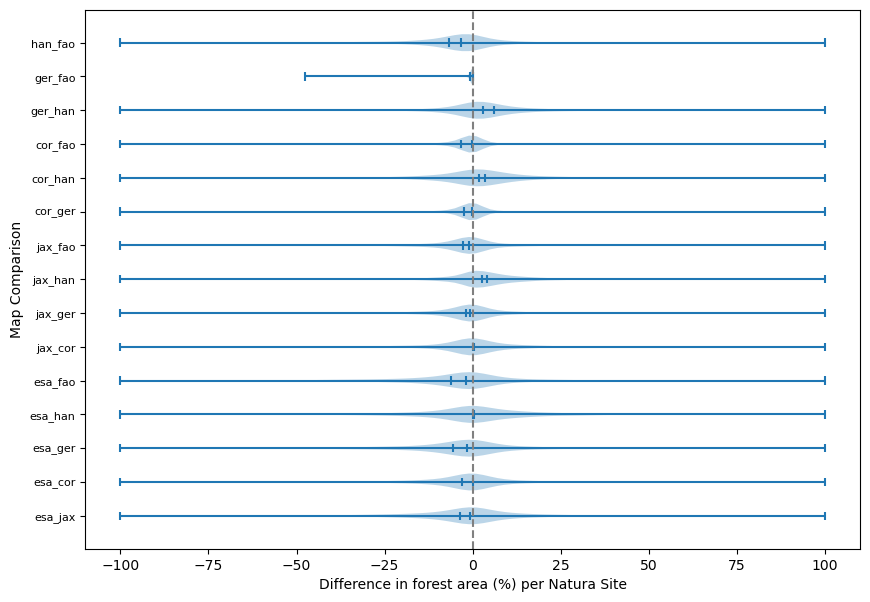

In [43]:
# Preparing figure
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating plot (make a horizontal version and show the mean)
violin_per_diff_rel = ax.violinplot(all_ttest_data_diffs_rel,
                         orientation = "horizontal",
                         showmeans=True,
                         showmedians=True,
                         side="both",
                         #showextrema=False
                         )

# Change the y-axis tick labels & adjust size
plt.yticks(range(1, 16), ["esa_jax", "esa_cor", "esa_ger", "esa_han", "esa_fao", "jax_cor", 
                          "jax_ger", "jax_han", "jax_fao", "cor_ger", "cor_han", "cor_fao", 
                          "ger_han", "ger_fao", "han_fao"
                          ])
plt.yticks(fontsize=8)

# Plot a vertical line for 0 for easier comparison
plt.axvline(0, color = 'grey', linestyle='--') 

# Set the axis labels
ax.set_ylabel('Map Comparison', fontsize = 10)
ax.set_xlabel('Difference in forest area (%) per Natura Site', fontsize = 10)

# Show the plot
plt.show()

### Step 2: Create Forest Presence/Absence Consensus map 

Sexton et al 2016 approach - basically just sum the FNF maps

In [ ]:
# 2: FOREST CONSENSUS MAP
# TAKES ABOUT 20 MIN

# Store paths to the FNF maps
esa_FNF = "./outputs/esa_lccs_class_3035_DE_5m_2018_FNF.tif"
jaxa_FNF = "./outputs/jaxa_FNF_3035_DE_5m_2018_FNF.tif"
corine_FNF = "./outputs/U2018_CLC2018_V2020_3035_DE_5m_2018_FNF.tif"
ger_lulc_FNF = "./outputs/clc5_class3xx_3035_DE_5m_2018_FNF.tif"
hansen_FNF = "./outputs/hansen_60cover_2018_3035_DE_5m_2018_FNF.tif"
fao_FNF = "./outputs/fao_approx_3035_DE_5m_2018_FNF.tif" 

# Runs gdal_calc.py to add the input rasters together (ABOUT 15 MIN w 5 rasters)
consensus_map = subprocess.run(['python', 
                                gdal_calc, 
                                '-A', esa_FNF, 
                                '-B', jaxa_FNF, 
                                '-C', corine_FNF, 
                                '-D', ger_lulc_FNF, 
                                '-E', hansen_FNF,
                                '-F', fao_FNF,
                                '--outfile=./outputs/forest_consensus_3035_DE_5m_2018.tif', 
                                '--calc=A+B+C+D+E+F', 
                                '--co=COMPRESS=LZW', 
                                '--co=BIGTIFF=YES', 
                                '--NoDataValue=-9999'
                                ],
                                capture_output=True, 
                                text=True)

print(consensus_map.stdout)
print(consensus_map.stderr)


0...10...20...30...40...50...60...70...80...90...100 - done.




### Step 3: Analyse Consensus Map

I follow a roughly similar process here as step 1 - first generating the zonal stats (this time only the pixel count per class as the consensus map is treated as categorical) and then generating some basic sums per Natura 2000 area and for all the Natura 2000 areas together. In the last section I generate some visualisations of the results. 

#### Step 3.1: Generate zonal statistics

Zonal stats (sum and count) per geometry for the consensus map
- Because the data is qualitative/categorical, make sure to use the categorical=True option and (optionally) the cmap parameter (see rasterstats documentation)

Convert to a feature collection


In [ ]:
# 3.1: CONSENSUS MAP ZONAL STATS 
# TAKES ABOUT 35 MIN

# Path to forest consensus map
consensus_map = "./outputs/forest_consensus_3035_DE_5m_2018.tif"

# Load the German Natura 2000 areas (w/o "RELEASE_DA" column as this causes problems later)
natura = gpd.read_file("./outputs/natura2000_3035_DE.shp", 
                       columns=["SITECODE", "SITENAME", "MS", "SITETYPE"])

# Calculate the consensus map zonal stats (count only) per class for each Natura 2000 geometry
consensus_natura_stats = zonal_stats(natura, consensus_map,
                                     categorical=True, geojson_output=True)


#### Step 3.2: Format into geodataframe

Unfortunately the geojson_output=True option does not seem to work when the categorical=True option is used. So in this step, I'll need to link up the results with the geometeries as well as format as a geodatabase.

Once things are properly formatted, I again save the outputs using pickle.dump() so that step 3.1 doesn't need to be run every time. 

In [ ]:
# 3.2: LINK TO GEOMETERIES & CREATE GDF

# Convert list of dictionaries to dataframe
consensus_natura_stats_df = pd.DataFrame(consensus_natura_stats)

# Rename the columns for clarity
consensus_natura_stats_df.columns=["0_count", "1_count", "2_count", "3_count",
                                   "4_count", "5_count", "6_count"
                                   ]

# Replace the NaN values with 0
consensus_natura_stats_df.fillna(0, inplace=True)

# Join Natura gdf (loaded as gdf in step 3.1) and consensus df (join based on index)
consensus_natura_stats_gdf = natura.join(consensus_natura_stats_df)


In [ ]:
# 3.2: SAVE GDF

# Save the geodataframe (so preceeding steps only need to be run once)
pickle.dump(consensus_natura_stats_gdf, open("./processing/consensus_natura_stats.p", "wb"))

In [10]:
#3.2: LOAD GDF
# START FROM HERE WHEN RETURNING TO SCRIPT

# Load the zonal stats output 
consensus_natura_stats_gdf = pickle.load(open("./processing/consensus_natura_stats.p", "rb"))

#### Step 3.3: Calculations

**Per Geometry**
1. Convert count per class to area values 
    - Each pixel is 5m x 5m = 25m2 or 0.0025 ha 
2. Calculate the total area per geometry (by summing class areas)
3. Calculate percentages per class by dividing each class area by the total area
4. Store the class with the highest percentage for each geometry

**For whole consensus map (for all Natura 2000 areas)**
3. Create a dataframe with the sum of the area for each class
4. Calculate the percentage of each class across all Natura areas

In [11]:
# 3.3: PER GEOMETRY CALCULATIONS

# Convert the counts per class to area (hectares)
consensus_natura_stats_gdf["0_area_ha"] = consensus_natura_stats_gdf["0_count"] * 0.0025
consensus_natura_stats_gdf["1_area_ha"] = consensus_natura_stats_gdf["1_count"] * 0.0025
consensus_natura_stats_gdf["2_area_ha"] = consensus_natura_stats_gdf["2_count"] * 0.0025
consensus_natura_stats_gdf["3_area_ha"] = consensus_natura_stats_gdf["3_count"] * 0.0025
consensus_natura_stats_gdf["4_area_ha"] = consensus_natura_stats_gdf["4_count"] * 0.0025
consensus_natura_stats_gdf["5_area_ha"] = consensus_natura_stats_gdf["5_count"] * 0.0025
consensus_natura_stats_gdf["6_area_ha"] = consensus_natura_stats_gdf["6_count"] * 0.0025

# Calculate the total area per geometry (by summing class areas)
consensus_natura_stats_gdf["total_area_ha"] = consensus_natura_stats_gdf["0_area_ha"] + \
                                              consensus_natura_stats_gdf["1_area_ha"] + \
                                              consensus_natura_stats_gdf["2_area_ha"] + \
                                              consensus_natura_stats_gdf["3_area_ha"] + \
                                              consensus_natura_stats_gdf["4_area_ha"] + \
                                              consensus_natura_stats_gdf["5_area_ha"] + \
                                              consensus_natura_stats_gdf["6_area_ha"] 

# Calculate the percentage of area for each class
consensus_natura_stats_gdf["0_percent"] = (consensus_natura_stats_gdf["0_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["1_percent"] = (consensus_natura_stats_gdf["1_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["2_percent"] = (consensus_natura_stats_gdf["2_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["3_percent"] = (consensus_natura_stats_gdf["3_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["4_percent"] = (consensus_natura_stats_gdf["4_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["5_percent"] = (consensus_natura_stats_gdf["5_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["6_percent"] = (consensus_natura_stats_gdf["6_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100

# Add a column for the class with the highest percentage
consensus_natura_stats_gdf["max_class"] = consensus_natura_stats_gdf[["0_percent", 
                                                                      "1_percent",
                                                                      "2_percent", 
                                                                      "3_percent",
                                                                      "4_percent",
                                                                      "5_percent",
                                                                      "6_percent"
                                                                      ]].idxmax(axis=1) 

# Replace the row values created in the last step to remove the word "percent"
consensus_natura_stats_gdf.replace("0_percent","0", inplace=True)
consensus_natura_stats_gdf.replace("1_percent","1", inplace=True)
consensus_natura_stats_gdf.replace("2_percent","2", inplace=True)
consensus_natura_stats_gdf.replace("3_percent","3", inplace=True)
consensus_natura_stats_gdf.replace("4_percent","4", inplace=True)
consensus_natura_stats_gdf.replace("5_percent","5", inplace=True)
consensus_natura_stats_gdf.replace("6_percent","6", inplace=True)

# Check
consensus_natura_stats_gdf[0:3]

C:\Users\ninam\AppData\Local\Temp\ipykernel_9344\3949201784.py:45: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  ]].idxmax(axis=1)


,MS,SITECODE,SITENAME,SITETYPE,geometry,0_count,1_count,2_count,3_count,4_count,...,6_area_ha,total_area_ha,0_percent,1_percent,2_percent,3_percent,4_percent,5_percent,6_percent,max_class
0,DE,DE1522301,Kalkquellmoor bei Klein Rheide,B,"POLYGON ((4286080.879 3484370.839, 4286192.964...",7672.0,0.0,0.0,0.0,0.0,...,0.0,19.1800,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,DE,DE1631304,Seegalendorfer Gehölz,B,"POLYGON ((4383163.901 3467566.091, 4383189.582...",58.0,70.0,107.0,130.0,970.0,...,0.0,12.7225,1.139713,1.375516,2.102574,2.554529,19.060719,73.766948,0.0,5
2,DE,DE1728351,Kalkflachmoor bei Mucheln,B,"POLYGON ((4348889.555 3461513.635, 4348877.247...",1593.0,499.0,222.0,273.0,1900.0,...,0.0,11.2175,35.502563,11.121016,4.947626,6.084243,42.344551,0.000000,0.0,4


In [12]:
# 3.3: WHOLE CONSENSUS MAP CALCULATIONS

# Create a dataframe with a row for the consensus map for storing the results
all_consensus_natura_stats = pd.DataFrame(range(0,7,1),
                                          columns= ["Class"])

# Create a new column for total area, filled with 0s
all_consensus_natura_stats["Total Area (ha)"] = 0.0

# Add the total area sums per class
all_consensus_natura_stats.iloc[0,1] = consensus_natura_stats_gdf["0_area_ha"].sum()
all_consensus_natura_stats.iloc[1,1] = consensus_natura_stats_gdf["1_area_ha"].sum()
all_consensus_natura_stats.iloc[2,1] = consensus_natura_stats_gdf["2_area_ha"].sum()
all_consensus_natura_stats.iloc[3,1] = consensus_natura_stats_gdf["3_area_ha"].sum()
all_consensus_natura_stats.iloc[4,1] = consensus_natura_stats_gdf["4_area_ha"].sum()
all_consensus_natura_stats.iloc[5,1] = consensus_natura_stats_gdf["5_area_ha"].sum()
all_consensus_natura_stats.iloc[6,1] = consensus_natura_stats_gdf["6_area_ha"].sum()

# Store the total area across all classes
total_area_all_classes = all_consensus_natura_stats["Total Area (ha)"].sum()

# Calculate the percentage coverage of each class
all_consensus_natura_stats["Percent Coverage"] = (all_consensus_natura_stats["Total Area (ha)"] / \
                                             total_area_all_classes) * 100

all_consensus_natura_stats


,Class,Total Area (ha),Percent Coverage
0,0,2.451305e+06,33.821688
1,1,3.842031e+05,5.301012
2,2,1.989283e+05,2.744697
3,3,3.369577e+05,4.649147
4,4,3.152147e+05,4.349150
5,5,7.222870e+05,9.965698
6,6,2.838835e+06,39.168608


#### Step 3.4: Visualisations

- Make a prettier table output out of the df
- Create a bar chart of total area in each class (see pic in "writing folder")
- ~~Create pie chart of percentage of each class (see pic in "writing folder")~~ pie charts seem to be generally regarded as a bad visualisation tool (difficult to read small differences) and I think it would also highlight that the "No Consensus" areas take up a relatively small percentage - which is fine but not necessarily what I want to highlight

- Create a figure showing the whole consensus map
- Create a map of Natura 2000 areas, showing the dominant class (highest percentage) for each geometry
- Create some figures for specific areas to highlight differences
    - find area with low consensus (e.g. TüpOhrdruf-Jonastal or Colbitz-Letzlinger Heide - almost all value of 3)
    - find area with high consensus
    - find area with mixed results



Help with table styling: https://pandas.pydata.org/docs/user_guide/style.html 

** I did a bit of experimenting with the visualisations here but as with step 1 I decided to do the visualisations outside of Python, so for this step I will actually just export the data to work with in R and QGIS.


In [13]:
# 3.4: EXPORT PER GEOM RESULTS

# Set the projection information for the gdf
consensus_natura_stats_gdf.set_crs("EPSG:3035")

# Save the per geometry results for each FNF map as shapefiles
consensus_natura_stats_gdf.to_file("./outputs/consensus_natura_stats_per_geom.shp")


C:\Users\ninam\AppData\Local\Temp\ipykernel_9344\1940219404.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  consensus_natura_stats_gdf.to_file("./outputs/consensus_natura_stats_per_geom.shp")
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_forest_thesis\thesis_env_conda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_area_ha' to 'total_area'
  ogr_write(


In [ ]:
# 3.4: EXPORT SUMMARY CONSENUS MAP RESULTS

# Export the df as a csv
all_consensus_natura_stats.to_csv("./outputs/all_consensus_natura_stats.csv")

### Tree Map Data Prep

Ross suggested creating a tree map with breakdown of classes and the combinations of FNF maps which make up these classes (which maps/forest definitions agree on which classes?) 

This requires some additional data processing. I will generate a one-level tree map (i.e. no sub-groups) for classes 1-5 (class 0 and class 6 are not needed because these are cases where all maps agree).

In terms of processing, I will follow the steps:
1. Create a mask layer for classes 1-5 inclusive 
2. Make combination maps by adding together different combinations of FNF maps
3. Mask each of the combo maps by multiplying by the different relevant masks
4. Run zonal statistics on each of the output maps (sum only)
5. Convert pixel sum to area sum (this is the total forest area)
6. Sum all geometries from each map and store as single gdf (for each class)
7. Export results (and then create tree map in R)

First I create a few functions which will be used for the different steps for each class.

In [2]:
# RECLASSIFY FUNCTION

# Create a function for running gdal_calc to reclassify a single input map
def reclass(input, output, reclass_rules):
    reclass = subprocess.run(['python', 
                              gdal_calc, 
                              '-A', input, 
                              '--outfile=' + output, 
                              '--calc=' + reclass_rules, 
                              '--co=COMPRESS=LZW', 
                              '--co=BIGTIFF=YES', 
                              '--NoDataValue=-9999'
                              ],
                              capture_output=True, 
                              text=True)
    print(reclass.stdout)
    print(reclass.stderr)


In [3]:
# MASK FUNCTION

# Create a function which iterates through a raster list and masks (multiplies) each by another raster
def mask(input_paths, output_ending, mask):
    for path in input_paths:
        # For output file naming: extract the input file name (with extension)
        name_w_ext = os.path.split(path)[1] 
        # For output file naming: remove extension from input file name
        name_wo_ext = os.path.splitext(name_w_ext)[0]
        # For output file naming: assemble the new file path for the output
        output_path = "./processing/" + name_wo_ext + output_ending 

        # Runs gdal_calc.py to multiply each input raster by the mask layer
        mask_map = subprocess.run(['python', 
                                gdal_calc, 
                                '-A', path, 
                                '-B', mask, 
                                '--outfile=' + output_path, 
                                '--calc=A*B', 
                                '--co=COMPRESS=LZW', 
                                '--co=BIGTIFF=YES', 
                                '--NoDataValue=-9999'
                                ],
                                capture_output=True, 
                                text=True)
        print(mask_map.stdout)
        print(mask_map.stderr)
        

In [4]:
# ZONAL STATS FUNCTION & NATURA LOADING

# Create a function which calculates the sum zonal statistics only (with no geometries returned)
def zonal_stats_sum_only(shapefile, raster_list):
    for raster_path in raster_list:
        # For output file naming: extract the input file name (with extension)
        name_w_ext = os.path.split(raster_path)[1] 
        # For output file naming: remove extension from input file name
        name_wo_ext = os.path.splitext(name_w_ext)[0]
        # For output file naming: assemble the new file path for the output
        output_path = "./processing/" + name_wo_ext + "_zonalstats.p" 

        # Run the zonal stats - calculating sum only (with no geometries returned)
        map_stats = zonal_stats(shapefile, raster_path,
                            stats=['sum']) 
          
        # Save the results as a dataframe
        stats_df = pd.DataFrame(map_stats)
        # Save the dataframe
        pickle.dump(stats_df, open(output_path, "wb"))


# Load the German Natura 2000 areas (w/o "RELEASE_DA" column as this causes problems later)
natura = gpd.read_file("./outputs/natura2000_3035_DE.shp", 
                       columns=["SITECODE", "SITENAME", "MS", "SITETYPE"])


In [ ]:
# CREATE CLASS MASKS
# e.g. for class 3: reclassify consensus map, 3 = 1, everything else = 0

# Store path to conensus map
consensus_input = "./outputs/forest_consensus_3035_DE_5m_2018.tif"

# Create paths for outputs
class1_mask = "./processing/consensus_class1_mask.tif"
class2_mask = "./processing/consensus_class2_mask.tif"
class3_mask = "./processing/consensus_class3_mask.tif"
class4_mask = "./processing/consensus_class4_mask.tif"
class5_mask = "./processing/consensus_class5_mask.tif"

# TAKES ABOUT 70 MIN
# Create the class masks, adjusting the reclassification rules for each output
reclass(consensus_input, class1_mask, "-9999*(A==-9999)+0*(A==0)+1*(A==1)+0*((A>=2)*(A<=6))")
reclass(consensus_input, class2_mask, "-9999*(A==-9999)+0*((A>=0)*(A<=1))+1*(A==2)+0*((A>=3)*(A<=6))")
reclass(consensus_input, class3_mask, "-9999*(A==-9999)+0*((A>=0)*(A<=2))+1*(A==3)+0*((A>=4)*(A<=6))")
reclass(consensus_input, class4_mask, "-9999*(A==-9999)+0*((A>=0)*(A<=3))+1*(A==4)+0*((A>=5)*(A<=6))")
reclass(consensus_input, class5_mask, "-9999*(A==-9999)+0*((A>=0)*(A<=4))+1*(A==5)+0*(A==6)")


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [5]:
# CLASS 1: MASKING

# Create a list of the paths to the relevant maps
fnf_maps =  glob.glob('./outputs/*_3035_DE_5m_2018_FNF.tif')

# Store path to the class 1 mask
class1_mask = "./processing/consensus_class1_mask.tif"

# Run the mask function on the relevant maps using the relevant mask
# EACH TAKES ABOUT 10 MIN
mask(fnf_maps, "_masked_class1.tif", class1_mask)


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [ ]:
# CLASS 1: ZONAL STATS

# Create a list of the paths to the masked class 1 data 
class1_outputs =  glob.glob('./processing/*_masked_class1.tif')

# Run zonal stats function for all class1 outputs (outputs convert to df & saved to file)
# TAKES ~140 MIN
zonal_stats_sum_only(natura, class1_outputs)

In [5]:
# CLASS 1: FORMAT & EXPORT

# Load the class 1 zonal stats output 
fao_class1_stats = pickle.load(open("./processing/fao_approx_3035_DE_5m_2018_FNF_masked_class1_zonalstats.p", "rb"))
ger_class1_stats = pickle.load(open("./processing/clc5_class3xx_3035_DE_5m_2018_FNF_masked_class1_zonalstats.p", "rb"))
corine_class1_stats = pickle.load(open("./processing/U2018_CLC2018_V2020_3035_DE_5m_2018_FNF_masked_class1_zonalstats.p", "rb"))
hansen_class1_stats = pickle.load(open("./processing/hansen_60cover_2018_3035_DE_5m_2018_FNF_masked_class1_zonalstats.p", "rb"))
jaxa_class1_stats = pickle.load(open("./processing/jaxa_FNF_3035_DE_5m_2018_FNF_masked_class1_zonalstats.p", "rb"))
esa_class1_stats = pickle.load(open("./processing/esa_lccs_class_3035_DE_5m_2018_FNF_masked_class1_zonalstats.p", "rb"))

# Combine into a single class1 df
tree_map_class1 = pd.concat([fao_class1_stats, ger_class1_stats, corine_class1_stats,
                           hansen_class1_stats, jaxa_class1_stats, esa_class1_stats
                           ], axis=1)

# Rename the columns to their corresponding FNF map
tree_map_class1.columns = ["fao", "ger", "corine", "hansen", "jaxa", "esa"]

# Sum all rows to get one value per column
tree_map_class1_sum = pd.DataFrame(tree_map_class1.sum(), columns=["sum"])

# Add new column for area (ha) results
tree_map_class1_sum["sum_ha"] = tree_map_class1_sum["sum"] * 0.0025

# Reset index so that the combo map name becomes a proper column
tree_map_class1_sum = tree_map_class1_sum.reset_index()

# Rename the columns
tree_map_class1_sum.columns = ["fnf_combo", "forest_pixels", "forest_area_ha"]

# Export the class 3 combo df as a csv
tree_map_class1_sum.to_csv("./outputs/treemap_class1_fnfcombo_natura_stats.csv")

# Check
tree_map_class1_sum


,fnf_combo,forest_pixels,forest_area_ha
0,fao,0.0,0.0000
1,ger,0.0,0.0000
2,corine,10027800.0,25069.5000
3,hansen,30487978.0,76219.9450
4,jaxa,30987164.0,77467.9100
5,esa,82178289.0,205445.7225


The above results make sense for fao and ger because the fao map has everything that's in ther ger map - so there will be no cases where either is the only map which indicates forest presence.

In [ ]:
# CLASS 2: CREATE 15 COMBO MAPS

# Store paths to the FNF maps
esa_FNF = "./outputs/esa_lccs_class_3035_DE_5m_2018_FNF.tif"
jaxa_FNF = "./outputs/jaxa_FNF_3035_DE_5m_2018_FNF.tif"
corine_FNF = "./outputs/U2018_CLC2018_V2020_3035_DE_5m_2018_FNF.tif"
ger_lulc_FNF = "./outputs/clc5_class3xx_3035_DE_5m_2018_FNF.tif"
hansen_FNF = "./outputs/hansen_60cover_2018_3035_DE_5m_2018_FNF.tif"
fao_FNF = "./outputs/fao_approx_3035_DE_5m_2018_FNF.tif" 

# Runs gdal_calc.py to add the input rasters together 
def combine_2FNF(input1, input2, output_path):
    combo_2map = subprocess.run(['python', 
                                 gdal_calc, 
                                 '-A', input1, 
                                 '-B', input2, 
                                 '--outfile=' + output_path, 
                                 '--calc=A+B', 
                                 '--co=COMPRESS=LZW', 
                                 '--co=BIGTIFF=YES', 
                                 '--NoDataValue=-9999'
                                 ],
                                 capture_output=True, 
                                 text=True)
    print(combo_2map.stdout)
    print(combo_2map.stderr)

# Create 15 different combinations (EACH ONE TAKES ABOUT 10 MIN)
combine_2FNF(esa_FNF, jaxa_FNF, "./processing/esa_jaxa_FNF_combo2.tif")
combine_2FNF(esa_FNF, corine_FNF, "./processing/esa_corine_FNF_combo2.tif")
combine_2FNF(esa_FNF, ger_lulc_FNF, "./processing/esa_gerlulc_FNF_combo2.tif")
combine_2FNF(esa_FNF, hansen_FNF, "./processing/esa_hansen_FNF_combo2.tif")
combine_2FNF(esa_FNF, fao_FNF, "./processing/esa_fao_FNF_combo2.tif")

combine_2FNF(jaxa_FNF, corine_FNF, "./processing/jaxa_corine_FNF_combo2.tif")
combine_2FNF(jaxa_FNF, ger_lulc_FNF, "./processing/jaxa_gerlulc_FNF_combo2.tif")
combine_2FNF(jaxa_FNF, hansen_FNF, "./processing/jaxa_hansen_FNF_combo2.tif")
combine_2FNF(jaxa_FNF, fao_FNF, "./processing/jaxa_fao_FNF_combo2.tif")

combine_2FNF(corine_FNF, ger_lulc_FNF, "./processing/corine_gerlulc_FNF_combo2.tif")
combine_2FNF(corine_FNF, hansen_FNF, "./processing/corine_hansen_FNF_combo2.tif")
combine_2FNF(corine_FNF, fao_FNF, "./processing/corine_fao_FNF_combo2.tif")

combine_2FNF(ger_lulc_FNF, hansen_FNF, "./processing/gerlulc_hansen_FNF_combo2.tif")
combine_2FNF(ger_lulc_FNF, fao_FNF, "./processing/gerlulc_fao_FNF_combo2.tif")

combine_2FNF(hansen_FNF, fao_FNF, "./processing/hansen_fao_FNF_combo2.tif")


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [ ]:
# CLASS 2: RECLASSIFY
# values of 2 = 1, anything less = 0

# Create a list of the paths to the combo maps
combo2_maps =  glob.glob('./processing/*_combo2.tif')

# Create a function which reclassifies rasters from a list (values of 2 to 1, everything else = 0)
def reclass_2combo(input_list):
    for input in input_list:
        # For output file naming: extract the input file name (with extension)
        name_w_ext = os.path.split(input)[1] 
        # For output file naming: remove extension from input file name
        name_wo_ext = os.path.splitext(name_w_ext)[0]
        # For output file naming: assemble the new file path for the output
        output_path = "./processing/" + name_wo_ext + "_reclass.tif" 
        
        # Use gdal_calc to reclass each input layer
        reclass_2FNF = subprocess.run(['python', 
                                      gdal_calc, 
                                      '-A', input, 
                                      '--outfile=' + output_path, 
                                      '--calc=-9999*(A==-9999)+0*((A>=0)*(A<=1))+1*(A==2)', 
                                      '--co=COMPRESS=LZW', 
                                      '--co=BIGTIFF=YES', 
                                      '--NoDataValue=-9999'
                                      ],
                                      capture_output=True, 
                                      text=True)
        print(reclass_2FNF.stdout)
        print(reclass_2FNF.stderr)

# Run reclass for all combo2 maps
# TAKES ~130 MIN
reclass_2combo(combo2_maps)


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [ ]:
# CLASS 2: MASKING

# Create a list of the paths to the combo maps
combo2_reclass =  glob.glob('./processing/*_combo2_reclass.tif')

# Store path to the class 2 mask
class2_mask = "./processing/consensus_class2_mask.tif"

# Run the mask function on the relevant maps using the relevant mask
# TAKES ABOUT ~135 MIN
mask(combo2_reclass, "_masked_class2.tif", class2_mask)


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [ ]:
# CLASS 2: ZONAL STATS 

# Create a list of the paths to the masked class 2 data 
class2_outputs =  glob.glob('./processing/*_masked_class2.tif')

# Run zonal stats function for all class2 outputs (outputs convert to df & saved to file)
# TAKES ~315 MIN
zonal_stats_sum_only(natura, class2_outputs)

In [13]:
# CLASS 2: FORMAT & EXPORT

# Load the class 2 zonal stats output 
corine_fao_class2_stats = pickle.load(open("./processing/corine_fao_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
corine_ger_class2_stats = pickle.load(open("./processing/corine_gerlulc_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
corine_hansen_class2_stats = pickle.load(open("./processing/corine_hansen_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
esa_corine_class2_stats = pickle.load(open("./processing/esa_corine_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
esa_fao_class2_stats = pickle.load(open("./processing/esa_fao_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
esa_ger_class2_stats = pickle.load(open("./processing/esa_gerlulc_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
esa_hansen_class2_stats = pickle.load(open("./processing/esa_hansen_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
esa_jaxa_class2_stats = pickle.load(open("./processing/esa_jaxa_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
ger_fao_class2_stats = pickle.load(open("./processing/gerlulc_fao_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
ger_hansen_class2_stats = pickle.load(open("./processing/gerlulc_hansen_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
hansen_fao_class2_stats = pickle.load(open("./processing/hansen_fao_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
jaxa_corine_class2_stats = pickle.load(open("./processing/jaxa_corine_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
jaxa_fao_class2_stats = pickle.load(open("./processing/jaxa_fao_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
jaxa_ger_class2_stats = pickle.load(open("./processing/jaxa_gerlulc_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))
jaxa_hansen_class2_stats = pickle.load(open("./processing/jaxa_hansen_FNF_combo2_reclass_masked_class2_zonalstats.p", "rb"))

# Combine into a single class2 df
tree_map_class2 = pd.concat([corine_fao_class2_stats, corine_ger_class2_stats,
                             corine_hansen_class2_stats, esa_corine_class2_stats,
                             esa_fao_class2_stats, esa_ger_class2_stats,
                             esa_hansen_class2_stats, esa_jaxa_class2_stats,
                             ger_fao_class2_stats, ger_hansen_class2_stats,
                             hansen_fao_class2_stats, jaxa_corine_class2_stats, 
                             jaxa_fao_class2_stats, jaxa_ger_class2_stats,
                             jaxa_hansen_class2_stats
                             ], axis=1)

# Rename the columns to their corresponding FNF map
tree_map_class2.columns = ["corine_fao", "corine_ger", "corine_hansen", "esa_corine", "esa_fao", 
                           "esa_ger", "esa_hansen", "esa_jaxa", "ger_fao", "ger_hansen", 
                           "hansen_fao", "jaxa_corine", "jaxa_fao", "jaxa_ger", "jaxa_hansen"
                           ]

# Sum all rows to get one value per column
tree_map_class2_sum = pd.DataFrame(tree_map_class2.sum(), columns=["sum"])

# Add new column for area (ha) results
tree_map_class2_sum["sum_ha"] = tree_map_class2_sum["sum"] * 0.0025

# Reset index so that the combo map name becomes a proper column
tree_map_class2_sum = tree_map_class2_sum.reset_index()

# Rename the columns
tree_map_class2_sum.columns = ["fnf_combo", "forest_pixels", "forest_area_ha"]

# Export the class 3 combo df as a csv
tree_map_class2_sum.to_csv("./outputs/treemap_class2_fnfcombo_natura_stats.csv")

# Check
tree_map_class2_sum


,fnf_combo,forest_pixels,forest_area_ha
0,corine_fao,0.0,0.0000
1,corine_ger,0.0,0.0000
2,corine_hansen,1915463.0,4788.6575
3,esa_corine,11211689.0,28029.2225
4,esa_fao,0.0,0.0000
5,esa_ger,0.0,0.0000
6,esa_hansen,13832245.0,34580.6125
7,esa_jaxa,17241283.0,43103.2075
8,ger_fao,14405381.0,36013.4525
9,ger_hansen,0.0,0.0000


In [ ]:
# CLASS 3: CREATE 20 COMBO MAPS

# Store paths to the FNF maps
esa = "./outputs/esa_lccs_class_3035_DE_5m_2018_FNF.tif"
jaxa = "./outputs/jaxa_FNF_3035_DE_5m_2018_FNF.tif"
corine = "./outputs/U2018_CLC2018_V2020_3035_DE_5m_2018_FNF.tif"
ger = "./outputs/clc5_class3xx_3035_DE_5m_2018_FNF.tif"
hansen = "./outputs/hansen_60cover_2018_3035_DE_5m_2018_FNF.tif"
fao = "./outputs/fao_approx_3035_DE_5m_2018_FNF.tif" 

# Runs gdal_calc.py to add the input rasters together 
def combine_3FNF(input1, input2, input3, output_path):
    combo_3map = subprocess.run(['python', 
                                 gdal_calc, 
                                 '-A', input1, 
                                 '-B', input2, 
                                 '-C', input3,
                                 '--outfile=' + output_path, 
                                 '--calc=A+B+C', 
                                 '--co=COMPRESS=LZW', 
                                 '--co=BIGTIFF=YES', 
                                 '--NoDataValue=-9999'
                                 ],
                                 capture_output=True, 
                                 text=True)
    print(combo_3map.stdout)
    print(combo_3map.stderr)

# Create 20 different combinations 

combine_3FNF(esa, jaxa, hansen, './processing/esa_jaxa_hansen_FNF_combo3.tif') 
combine_3FNF(esa, jaxa, corine, './processing/esa_jaxa_corine_FNF_combo3.tif')
combine_3FNF(esa, jaxa, ger, './processing/esa_jaxa_ger_FNF_combo3.tif')
combine_3FNF(esa, jaxa, fao, './processing/esa_jaxa_fao_FNF_combo3.tif')
combine_3FNF(esa, hansen, corine, './processing/esa_hansen_corine_FNF_combo3.tif')
combine_3FNF(esa, hansen, ger, './processing/esa_hansen_ger_FNF_combo3.tif')
combine_3FNF(esa, hansen, fao, './processing/esa_hansen_fao_FNF_combo3.tif')
combine_3FNF(esa, corine, ger, './processing/esa_corine_ger_FNF_combo3.tif')
combine_3FNF(esa, corine, fao, './processing/esa_corine_fao_FNF_combo3.tif')
combine_3FNF(esa, ger, fao, './processing/esa_ger_fao_FNF_combo3.tif')

combine_3FNF(jaxa, hansen, corine, './processing/jaxa_hansen_corine_FNF_combo3.tif')
combine_3FNF(jaxa, hansen, ger, './processing/jaxa_hansen_ger_FNF_combo3.tif')
combine_3FNF(jaxa, hansen, fao, './processing/jaxa_hansen_fao_FNF_combo3.tif')
combine_3FNF(jaxa, corine, ger, './processing/jaxa_corine_ger_FNF_combo3.tif')
combine_3FNF(jaxa, corine, fao, './processing/jaxa_corine_fao_FNF_combo3.tif')
combine_3FNF(jaxa, ger, fao, './processing/jaxa_ger_fao_FNF_combo3.tif')

combine_3FNF(hansen, corine, ger, './processing/hansen_corine_ger_FNF_combo3.tif')
combine_3FNF(hansen, corine, fao, './processing/hansen_corine_fao_FNF_combo3.tif')
combine_3FNF(hansen, ger, fao, './processing/hansen_ger_fao_FNF_combo3.tif')

combine_3FNF(corine, ger, fao, './processing/corine_ger_fao_FNF_combo3.tif')


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [ ]:
# CLASS 3: RECLASSIFY
# values of 3 = 1, anything less = 0

# Create a list of the paths to the combo maps
combo3_maps =  glob.glob('./processing/*_combo3.tif')

# Create a function which reclassifies rasters from a list (values of 3 to 1, everything else = 0)
def reclass_3combo(input_list):
    for input in input_list:
        # For output file naming: extract the input file name (with extension)
        name_w_ext = os.path.split(input)[1] 
        # For output file naming: remove extension from input file name
        name_wo_ext = os.path.splitext(name_w_ext)[0]
        # For output file naming: assemble the new file path for the output
        output_path = "./processing/" + name_wo_ext + "_reclass.tif" 
        
        # Use gdal_calc to reclass each input layer
        reclass_3FNF = subprocess.run(['python', 
                                      gdal_calc, 
                                      '-A', input, 
                                      '--outfile=' + output_path, 
                                      '--calc=-9999*(A==-9999)+0*((A>=0)*(A<=2))+1*(A==3)', 
                                      '--co=COMPRESS=LZW', 
                                      '--co=BIGTIFF=YES', 
                                      '--NoDataValue=-9999'
                                      ],
                                      capture_output=True, 
                                      text=True)
        print(reclass_3FNF.stdout)
        print(reclass_3FNF.stderr)

# Run reclass for all combo3 maps
# TAKES ~3.5 HOURS
reclass_3combo(combo3_maps)


In [ ]:
# CLASS 3: MASKING

# Create a list of the paths to the combo maps
combo3_reclass =  glob.glob('./processing/*_combo3_reclass.tif')

# Store path to the class 3 mask
class3_mask = "./processing/consensus_class3_mask.tif"

# Run the mask function on the relevant maps using the relevant mask
# TAKES ABOUT ~3.5 HOURS
mask(combo3_reclass, "_masked_class3.tif", class3_mask)

0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - 

In [ ]:
# CLASS 3: ZONAL STATS 

# Create a list of the paths to the masked class 3 data 
class3_outputs =  glob.glob('./processing/*_masked_class3.tif')

# Run zonal stats function for all class3 outputs (outputs convert to df & saved to file)
# TAKES ~6.5 HOURS
zonal_stats_sum_only(natura, class3_outputs)

In [12]:
# CLASS 3: FORMAT & EXPORT

# Load the class 3 zonal stats output 
corine_ger_fao_class3_stats = pickle.load(open("./processing/corine_ger_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
jaxa_hansen_ger_class3_stats = pickle.load(open("./processing/jaxa_hansen_ger_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
jaxa_hansen_fao_class3_stats = pickle.load(open("./processing/jaxa_hansen_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
jaxa_hansen_corine_class3_stats = pickle.load(open("./processing/jaxa_hansen_corine_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
jaxa_ger_fao_class3_stats = pickle.load(open("./processing/jaxa_ger_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
jaxa_corine_ger_class3_stats = pickle.load(open("./processing/jaxa_corine_ger_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
jaxa_corine_fao_class3_stats = pickle.load(open("./processing/jaxa_corine_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
hansen_ger_fao_class3_stats = pickle.load(open("./processing/hansen_ger_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
hansen_corine_ger_class3_stats = pickle.load(open("./processing/hansen_corine_ger_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
hansen_corine_fao_class3_stats = pickle.load(open("./processing/hansen_corine_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_jaxa_hansen_class3_stats = pickle.load(open("./processing/esa_jaxa_hansen_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_jaxa_ger_class3_stats = pickle.load(open("./processing/esa_jaxa_ger_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_jaxa_fao_class3_stats = pickle.load(open("./processing/esa_jaxa_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_jaxa_corine_class3_stats = pickle.load(open("./processing/esa_jaxa_corine_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_hansen_ger_class3_stats = pickle.load(open("./processing/esa_hansen_ger_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_hansen_fao_class3_stats = pickle.load(open("./processing/esa_hansen_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_hansen_corine_class3_stats = pickle.load(open("./processing/esa_hansen_corine_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_ger_fao_class3_stats = pickle.load(open("./processing/esa_ger_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_corine_ger_class3_stats = pickle.load(open("./processing/esa_corine_ger_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))
esa_corine_fao_class3_stats = pickle.load(open("./processing/esa_corine_fao_FNF_combo3_reclass_masked_class3_zonalstats.p", "rb"))


# Combine into a single class2 df
tree_map_class3 = pd.concat([corine_ger_fao_class3_stats, jaxa_hansen_ger_class3_stats,
                             jaxa_hansen_fao_class3_stats, jaxa_hansen_corine_class3_stats,
                             jaxa_ger_fao_class3_stats, jaxa_corine_ger_class3_stats,
                             jaxa_corine_fao_class3_stats, hansen_ger_fao_class3_stats,
                             hansen_corine_ger_class3_stats, hansen_corine_fao_class3_stats,
                             esa_jaxa_hansen_class3_stats, esa_jaxa_ger_class3_stats,
                             esa_jaxa_fao_class3_stats, esa_jaxa_corine_class3_stats,
                             esa_hansen_ger_class3_stats, esa_hansen_fao_class3_stats,
                             esa_hansen_corine_class3_stats, esa_ger_fao_class3_stats,
                             esa_corine_ger_class3_stats, esa_corine_fao_class3_stats
                             ], axis=1)

# Rename the columns to their corresponding FNF map
tree_map_class3.columns = ["corine_ger_fao", "jaxa_hansen_ger", "jaxa_hansen_fao", 
                           "jaxa_hansen_corine", "jaxa_ger_fao", "jaxa_corine_ger",
                           "jaxa_corine_fao", "hansen_ger_fao", "hansen_corine_ger",
                           "hansen_corine_fao", "esa_jaxa_hansen", "esa_jaxa_ger",
                           "esa_jaxa_fao", "esa_jaxa_corine", "esa_hansen_ger",
                           "esa_hansen_fao", "esa_hansen_corine", "esa_ger_fao",
                           "esa_corine_ger", "esa_corine_fao"
                           ]

# Sum all rows to get one value per column
tree_map_class3_sum = pd.DataFrame(tree_map_class3.sum(), columns=["sum"])

# Add new column for area (ha) results
tree_map_class3_sum["sum_ha"] = tree_map_class3_sum["sum"] * 0.0025

# Reset index so that the combo map name becomes a proper column
tree_map_class3_sum = tree_map_class3_sum.reset_index()

# Rename the columns
tree_map_class3_sum.columns = ["fnf_combo", "forest_pixels", "forest_area_ha"]

# Export the class 3 combo df as a csv
tree_map_class3_sum.to_csv("./outputs/treemap_class3_fnfcombo_natura_stats.csv")

# Check
tree_map_class3_sum

,fnf_combo,forest_pixels,forest_area_ha
0,corine_ger_fao,86930466.0,217326.1650
1,jaxa_hansen_ger,0.0,0.0000
2,jaxa_hansen_fao,1254050.0,3135.1250
3,jaxa_hansen_corine,1394825.0,3487.0625
4,jaxa_ger_fao,7214840.0,18037.1000
5,jaxa_corine_ger,0.0,0.0000
6,jaxa_corine_fao,616361.0,1540.9025
7,hansen_ger_fao,6853803.0,17134.5075
8,hansen_corine_ger,0.0,0.0000
9,hansen_corine_fao,0.0,0.0000


In [ ]:
# CLASS 4: CREATE 15 COMBO MAPS

# Store paths to SOME the reclassed 2 combo FNF maps
# Not all 2 combo maps are needed to make unique combinations of 4
esa_corine = "./processing/esa_corine_FNF_combo2_reclass.tif"
esa_hansen = "./processing/esa_hansen_FNF_combo2_reclass.tif"
esa_jaxa = "./processing/esa_jaxa_FNF_combo2_reclass.tif"

corine_fao = "./processing/corine_fao_FNF_combo2_reclass.tif"
corine_ger = "./processing/corine_gerlulc_FNF_combo2_reclass.tif"
corine_hansen = "./processing/corine_hansen_FNF_combo2_reclass.tif"

jaxa_corine = "./processing/jaxa_corine_FNF_combo2_reclass.tif"
jaxa_hansen = "./processing/jaxa_hansen_FNF_combo2_reclass.tif"

ger_fao = "./processing/gerlulc_fao_FNF_combo2_reclass.tif"
ger_hansen = "./processing/gerlulc_hansen_FNF_combo2_reclass.tif"

hansen_fao = "./processing/hansen_fao_FNF_combo2_reclass.tif"  

# Runs gdal_calc.py to add the input rasters together 
def combine_2FNF(input1, input2, output_path):
    combo_2map = subprocess.run(['python', 
                                 gdal_calc, 
                                 '-A', input1, 
                                 '-B', input2, 
                                 '--outfile=' + output_path, 
                                 '--calc=A+B', 
                                 '--co=COMPRESS=LZW', 
                                 '--co=BIGTIFF=YES', 
                                 '--NoDataValue=-9999'
                                 ],
                                 capture_output=True, 
                                 text=True)
    print(combo_2map.stdout)
    print(combo_2map.stderr)

# Create 15 different combinations 
combine_2FNF(esa_jaxa, corine_hansen, "./processing/esa_jaxa_corine_hansen_FNF_combo4.tif")
combine_2FNF(esa_jaxa, ger_hansen, "./processing/esa_jaxa_ger_hansen_FNF_combo4.tif")
combine_2FNF(esa_jaxa, hansen_fao, "./processing/esa_jaxa_hansen_fao_FNF_combo4.tif")
combine_2FNF(esa_jaxa, corine_ger, "./processing/esa_jaxa_corine_ger_FNF_combo4.tif")
combine_2FNF(esa_jaxa, corine_fao, "./processing/esa_jaxa_corine_fao_FNF_combo4.tif")
combine_2FNF(esa_jaxa, ger_fao, "./processing/esa_jaxa_ger_fao_FNF_combo4.tif")

combine_2FNF(esa_hansen, corine_ger, "./processing/esa_hansen_corine_ger_FNF_combo4.tif")
combine_2FNF(esa_hansen, corine_fao, "./processing/esa_hansen_corine_fao_FNF_combo4.tif")
combine_2FNF(esa_hansen, ger_fao, "./processing/esa_hansen_ger_fao_FNF_combo4.tif")

combine_2FNF(esa_corine, ger_fao, "./processing/esa_corine_ger_fao_FNF_combo4.tif")

combine_2FNF(jaxa_hansen, corine_ger, "./processing/jaxa_hansen_corine_ger_FNF_combo4.tif")
combine_2FNF(jaxa_hansen, corine_fao, "./processing/jaxa_hansen_corine_fao_FNF_combo4.tif")
combine_2FNF(jaxa_hansen, ger_fao, "./processing/jaxa_hansen_ger_fao_FNF_combo4.tif")

combine_2FNF(jaxa_corine, ger_fao, "./processing/jaxa_corine_ger_fao_FNF_combo4.tif")

combine_2FNF(corine_hansen, ger_fao, "./processing/corine_hansen_ger_fao_FNF_combo4.tif")


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [10]:
# CLASS 4: RECLASSIFY
# values of 2 = 1, anything less = 0 (because these combo4 maps are made from 2 masked combo2 maps)

# Create a list of the paths to the combo maps
combo4_maps =  glob.glob('./processing/*_combo4.tif')

# Create a function which reclassifies rasters from a list (values of 2 to 1, everything else = 0)
def reclass_4combo(input_list):
    for input in input_list:
        # For output file naming: extract the input file name (with extension)
        name_w_ext = os.path.split(input)[1] 
        # For output file naming: remove extension from input file name
        name_wo_ext = os.path.splitext(name_w_ext)[0]
        # For output file naming: assemble the new file path for the output
        output_path = "./processing/" + name_wo_ext + "_reclass.tif" 
        
        # Use gdal_calc to reclass each input layer
        reclass_2FNF = subprocess.run(['python', 
                                      gdal_calc, 
                                      '-A', input, 
                                      '--outfile=' + output_path, 
                                      '--calc=-9999*(A==-9999)+0*((A>=0)*(A<=1))+1*(A==2)', 
                                      '--co=COMPRESS=LZW', 
                                      '--co=BIGTIFF=YES', 
                                      '--NoDataValue=-9999'
                                      ],
                                      capture_output=True, 
                                      text=True)
        print(reclass_2FNF.stdout)
        print(reclass_2FNF.stderr)

# Run reclass for all combo4 maps
# TAKES ~2.5 HOURS
reclass_4combo(combo4_maps)

0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [ ]:
# CLASS 4: MASKING

# Create a list of the paths to the combo maps
combo4_reclass =  glob.glob('./processing/*_combo4_reclass.tif')

# Store path to the class 4 mask
class4_mask = "./processing/consensus_class4_mask.tif"

# Run the mask function on the relevant maps using the relevant mask
# TAKES ~2 HOURS
mask(combo4_reclass, "_masked_class4.tif", class4_mask)

0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [14]:
# CLASS 4: ZONAL STATS 

# Create a list of the paths to the masked class 4 data 
class4_outputs =  glob.glob('./processing/*_masked_class4.tif')

# Run zonal stats function for all class4 outputs (outputs convert to df & saved to file)
zonal_stats_sum_only(natura, class4_outputs)

In [15]:
# CLASS 4: FORMAT & EXPORT

# Load the class 4 zonal stats output 
esa_jaxa_corine_hansen_class4_stats = pickle.load(open("./processing/esa_jaxa_corine_hansen_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_jaxa_ger_hansen_class4_stats = pickle.load(open("./processing/esa_jaxa_ger_hansen_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_jaxa_hansen_fao_class4_stats = pickle.load(open("./processing/esa_jaxa_hansen_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_jaxa_corine_ger_class4_stats = pickle.load(open("./processing/esa_jaxa_corine_ger_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_jaxa_corine_fao_class4_stats = pickle.load(open("./processing/esa_jaxa_corine_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_jaxa_ger_fao_class4_stats = pickle.load(open("./processing/esa_jaxa_ger_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_hansen_corine_ger_class4_stats = pickle.load(open("./processing/esa_hansen_corine_ger_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_hansen_corine_fao_class4_stats = pickle.load(open("./processing/esa_hansen_corine_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_hansen_ger_fao_class4_stats = pickle.load(open("./processing/esa_hansen_ger_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
esa_corine_ger_fao_class4_stats = pickle.load(open("./processing/esa_corine_ger_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
jaxa_hansen_corine_ger_class4_stats = pickle.load(open("./processing/jaxa_hansen_corine_ger_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
jaxa_hansen_corine_fao_class4_stats = pickle.load(open("./processing/jaxa_hansen_corine_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
jaxa_hansen_ger_fao_class4_stats = pickle.load(open("./processing/jaxa_hansen_ger_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
jaxa_corine_ger_fao_class4_stats = pickle.load(open("./processing/jaxa_corine_ger_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))
corine_hansen_ger_fao_class4_stats = pickle.load(open("./processing/corine_hansen_ger_fao_FNF_combo4_reclass_masked_class4_zonalstats.p", "rb"))

# Combine into a single class2 df
tree_map_class4 = pd.concat([esa_jaxa_corine_hansen_class4_stats, esa_jaxa_ger_hansen_class4_stats,
                             esa_jaxa_hansen_fao_class4_stats, esa_jaxa_corine_ger_class4_stats,
                             esa_jaxa_corine_fao_class4_stats, esa_jaxa_ger_fao_class4_stats,
                             esa_hansen_corine_ger_class4_stats, esa_hansen_corine_fao_class4_stats,
                             esa_hansen_ger_fao_class4_stats, esa_corine_ger_fao_class4_stats,
                             jaxa_hansen_corine_ger_class4_stats, jaxa_hansen_corine_fao_class4_stats,
                             jaxa_hansen_ger_fao_class4_stats, jaxa_corine_ger_fao_class4_stats,
                             corine_hansen_ger_fao_class4_stats
                             ], axis=1)

# Rename the columns to their corresponding FNF map
tree_map_class4.columns = ["esa_jaxa_corine_hansen", "esa_jaxa_ger_hansen", "esa_jaxa_hansen_fao",
                           "esa_jaxa_corine_ger", "esa_jaxa_corine_fao", "esa_jaxa_ger_fao",
                           "esa_hansen_corine_ger", "esa_hansen_corine_fao", "esa_hansen_ger_fao",
                           "esa_corine_ger_fao", "jaxa_hansen_corine_ger", "jaxa_hansen_corine_fao",
                           "jaxa_hansen_ger_fao", "jaxa_corine_ger_fao", "corine_hansen_ger_fao"
                           ]

# Sum all rows to get one value per column
tree_map_class4_sum = pd.DataFrame(tree_map_class4.sum(), columns=["sum"])

# Add new column for area (ha) results
tree_map_class4_sum["sum_ha"] = tree_map_class4_sum["sum"] * 0.0025

# Reset index so that the combo map name becomes a proper column
tree_map_class4_sum = tree_map_class4_sum.reset_index()

# Rename the columns
tree_map_class4_sum.columns = ["fnf_combo", "forest_pixels", "forest_area_ha"]

# Export the class 4 combo df as a csv
tree_map_class4_sum.to_csv("./outputs/treemap_class4_fnfcombo_natura_stats.csv")

# Check
tree_map_class4_sum

,fnf_combo,forest_pixels,forest_area_ha
0,esa_jaxa_corine_hansen,6683398.0,16708.4950
1,esa_jaxa_ger_hansen,0.0,0.0000
2,esa_jaxa_hansen_fao,2522192.0,6305.4800
3,esa_jaxa_corine_ger,0.0,0.0000
4,esa_jaxa_corine_fao,1352182.0,3380.4550
5,esa_jaxa_ger_fao,2857992.0,7144.9800
6,esa_hansen_corine_ger,0.0,0.0000
7,esa_hansen_corine_fao,0.0,0.0000
8,esa_hansen_ger_fao,2639694.0,6599.2350
9,esa_corine_ger_fao,42888340.0,107220.8500


In [ ]:
# CLASS 5: CREATE 6 COMBO MAPS

# Store paths to SOME the reclassed 2 and 3 combo FNF maps
# Not all 2 and 3 combo maps are needed to make unique combinations of 5
esa_jaxa_hansen = "./processing/esa_jaxa_hansen_FNF_combo3_reclass.tif"
esa_jaxa_corine = "./processing/esa_jaxa_corine_FNF_combo3_reclass.tif"
esa_hansen_corine = "./processing/esa_hansen_corine_FNF_combo3_reclass.tif"
jaxa_hansen_corine = "./processing/jaxa_hansen_corine_FNF_combo3_reclass.tif"

corine_ger = "./processing/corine_gerlulc_FNF_combo2_reclass.tif"
corine_fao = "./processing/corine_fao_FNF_combo2_reclass.tif"
ger_fao = "./processing/gerlulc_fao_FNF_combo2_reclass.tif"


# Runs gdal_calc.py to add the input rasters together 
def combine_2FNF(input1, input2, output_path):
    combo_2map = subprocess.run(['python', 
                                 gdal_calc, 
                                 '-A', input1, 
                                 '-B', input2, 
                                 '--outfile=' + output_path, 
                                 '--calc=A+B', 
                                 '--co=COMPRESS=LZW', 
                                 '--co=BIGTIFF=YES', 
                                 '--NoDataValue=-9999'
                                 ],
                                 capture_output=True, 
                                 text=True)
    print(combo_2map.stdout)
    print(combo_2map.stderr)

# Create 6 different combinations 
combine_2FNF(esa_jaxa_hansen, corine_ger, "./processing/esa_jaxa_hansen_corine_ger_FNF_combo5.tif")
combine_2FNF(esa_jaxa_hansen, corine_fao, "./processing/esa_jaxa_hansen_corine_fao_FNF_combo5.tif")
combine_2FNF(esa_jaxa_hansen, ger_fao, "./processing/esa_jaxa_hansen_ger_fao_FNF_combo5.tif")
combine_2FNF(esa_jaxa_corine, ger_fao, "./processing/esa_jaxa_corine_ger_fao_FNF_combo5.tif")
combine_2FNF(esa_hansen_corine, ger_fao, "./processing/esa_hansen_corine_ger_fao_FNF_combo5.tif")
combine_2FNF(jaxa_hansen_corine, ger_fao, "./processing/jaxa_hansen_corine_ger_fao_FNF_combo5.tif")


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [5]:
# CLASS 5: RECLASSIFY
# values of 2 = 1, anything less = 0 (because these combo5 maps are made from 2 masked combo2/3 maps)

# Create a list of the paths to the combo maps
combo5_maps =  glob.glob('./processing/*_combo5.tif')

# Create a function which reclassifies rasters from a list (values of 2 to 1, everything else = 0)
def reclass_5combo(input_list):
    for input in input_list:
        # For output file naming: extract the input file name (with extension)
        name_w_ext = os.path.split(input)[1] 
        # For output file naming: remove extension from input file name
        name_wo_ext = os.path.splitext(name_w_ext)[0]
        # For output file naming: assemble the new file path for the output
        output_path = "./processing/" + name_wo_ext + "_reclass.tif" 
        
        # Use gdal_calc to reclass each input layer
        reclass_2FNF = subprocess.run(['python', 
                                      gdal_calc, 
                                      '-A', input, 
                                      '--outfile=' + output_path, 
                                      '--calc=-9999*(A==-9999)+0*((A>=0)*(A<=1))+1*(A==2)', 
                                      '--co=COMPRESS=LZW', 
                                      '--co=BIGTIFF=YES', 
                                      '--NoDataValue=-9999'
                                      ],
                                      capture_output=True, 
                                      text=True)
        print(reclass_2FNF.stdout)
        print(reclass_2FNF.stderr)

# Run reclass for all combo4 maps
reclass_5combo(combo5_maps)

0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [6]:
# CLASS 5: MASKING

# Create a list of the paths to the combo maps
combo5_reclass =  glob.glob('./processing/*_combo5_reclass.tif')

# Store path to the class 5 mask
class5_mask = "./processing/consensus_class5_mask.tif"

# Run the mask function on the relevant maps using the relevant mask
mask(combo5_reclass, "_masked_class5.tif", class5_mask)

0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.


0...10...20...30...40...50...60...70...80...90...100 - done.




In [7]:
# CLASS 5: ZONAL STATS 

# Create a list of the paths to the masked class 5 data 
class5_outputs =  glob.glob('./processing/*_masked_class5.tif')

# Run zonal stats function for all class5 outputs (outputs convert to df & saved to file)
zonal_stats_sum_only(natura, class5_outputs)

In [18]:
# CLASS 5: FORMAT & EXPORT

# Load the class 5 zonal stats output 
esa_jaxa_hansen_corine_ger_class5_stats = pickle.load(open("./processing/esa_jaxa_hansen_corine_ger_FNF_combo5_reclass_masked_class5_zonalstats.p", "rb"))
esa_jaxa_hansen_corine_fao_class5_stats = pickle.load(open("./processing/esa_jaxa_hansen_corine_fao_FNF_combo5_reclass_masked_class5_zonalstats.p", "rb"))
esa_jaxa_hansen_ger_fao_class5_stats = pickle.load(open("./processing/esa_jaxa_hansen_ger_fao_FNF_combo5_reclass_masked_class5_zonalstats.p", "rb"))
esa_jaxa_corine_ger_fao_class5_stats = pickle.load(open("./processing/esa_jaxa_corine_ger_fao_FNF_combo5_reclass_masked_class5_zonalstats.p", "rb"))
esa_hansen_corine_ger_fao_class5_stats = pickle.load(open("./processing/esa_hansen_corine_ger_fao_FNF_combo5_reclass_masked_class5_zonalstats.p", "rb"))
jaxa_hansen_corine_ger_fao_class5_stats = pickle.load(open("./processing/jaxa_hansen_corine_ger_fao_FNF_combo5_reclass_masked_class5_zonalstats.p", "rb"))

# Combine into a single class2 df
tree_map_class5 = pd.concat([esa_jaxa_hansen_corine_ger_class5_stats, 
                             esa_jaxa_hansen_corine_fao_class5_stats,
                             esa_jaxa_hansen_ger_fao_class5_stats,
                             esa_jaxa_corine_ger_fao_class5_stats,
                             esa_hansen_corine_ger_fao_class5_stats,
                             jaxa_hansen_corine_ger_fao_class5_stats
                             ], axis=1)

# Rename the columns to their corresponding FNF map
tree_map_class5.columns = ["esa_jaxa_hansen_corine_ger",
                           "esa_jaxa_hansen_corine_fao",
                           "esa_jaxa_hansen_ger_fao",
                           "esa_jaxa_corine_ger_fao",
                           "esa_hansen_corine_ger_fao",
                           "jaxa_hansen_corine_ger_fao",
                           ]

# Sum all rows to get one value per column
tree_map_class5_sum = pd.DataFrame(tree_map_class5.sum(), columns=["sum"])

# Add new column for area (ha) results
tree_map_class5_sum["sum_ha"] = tree_map_class5_sum["sum"] * 0.0025

# Reset index so that the combo map name becomes a proper column
tree_map_class5_sum = tree_map_class5_sum.reset_index()

# Rename the columns
tree_map_class5_sum.columns = ["fnf_combo", "forest_pixels", "forest_area_ha"]

# Export the class 5 combo df as a csv
tree_map_class5_sum.to_csv("./outputs/treemap_class5_fnfcombo_natura_stats.csv")

# Check
tree_map_class5_sum

,fnf_combo,forest_pixels,forest_area_ha
0,esa_jaxa_hansen_corine_ger,0.0,0.0000
1,esa_jaxa_hansen_corine_fao,1307901.0,3269.7525
2,esa_jaxa_hansen_ger_fao,6497864.0,16244.6600
3,esa_jaxa_corine_ger_fao,143319312.0,358298.2800
4,esa_hansen_corine_ger_fao,47767498.0,119418.7450
5,jaxa_hansen_corine_ger_fao,90022206.0,225055.5150
